# Analiza Pobudzenia i Hamowania Układu Nerwowego - WESAD

## Cel analizy

Ten notebook analizuje **trzy wybrane osoby** z bazy WESAD pod kątem:

1. **Jak szybko się pobudza ich układ nerwowy** (reaktywność SNS)
2. **Ile czasu są w stanie pobudzenia** (czas utrzymania)
3. **Jak szybko się wyciszają** (recovery PNS)

## Teoria neurobiologiczna

### Układ pobudzenia (SNS - Sympatyczny)
- EDA idzie w górę
- HR/BVP rosną
- Napięcie mięśni rośnie
- Przyspieszony oddech
- To "mobilizacja", fight/flight

### Układ hamowania (PNS - Parasympatyczny)
- Wygaszanie EDA
- HR wraca do baseline
- BVP się uspokaja
- Powrót do równowagi wegetatywnej
- To "calm-down", recovery

## Metryki do obliczenia

### Z układu pobudzenia (SNS):
**Z EDA:**
- Czas narastania (rise time)
- Amplituda skoku (peak amplitude)
- Liczba mikroreakcji (number of peaks)
- Tonic level vs. phasic peaks

**Z BVP/HR:**
- Przyspieszenie tętna (HR acceleration)
- Zmniejszenie HRV (HRV reduction)
- Gwałtowne zmiany w pulsie

### Z układu hamowania (PNS):
**Z EDA:**
- Slope wygaszania (recovery slope)
- Czas powrotu do baseline (recovery time)
- Głębokość regulacji

**Z HRV:**
- Wzrost HRV po stresie
- Dynamika stabilizacji

## Profil Regulacji Emocjonalnej

Na podstawie tych metryk tworzymy profil każdej osoby:
- **Wysoka reaktywność + słabe hamowanie** → profil "lękowo-pobudliwy"
- **Niska reaktywność + szybkie wygaszanie** → profil "stabilny, odporny"
- **Długie utrzymywanie pobudzenia** → dysregulacja autonomiczna

## Ważne założenia

- **Każdego pacjenta badamy osobno**
- **Sygnały muszą być stacjonarne dla ARIMA** (testy ADF/KPSS)
- **Używamy danych WESAD** (EDA, BVP, TEMP, ACC)


## KROK 0: Instalacja brakujących bibliotek (opcjonalnie)


In [1]:
# ============================================================================
# KROK 0: INSTALACJA BRAKUJĄCYCH BIBLIOTEK (OPCJONALNIE)
# ============================================================================
# 
# Jeśli PyEMD lub nolds nie są dostępne, uruchom tę komórkę.
# Zainstaluje pakiety w środowisku używanym przez Jupyter.
#
# Uwaga: Może to chwilę potrwać przy pierwszym uruchomieniu.

import sys
import subprocess

def install_package(package_name):
    """Instaluje pakiet w środowisku używanym przez Jupyter"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_name, "--quiet"])
        print(f"✅ {package_name} zainstalowane pomyślnie")
        return True
    except subprocess.CalledProcessError as e:
        print(f"❌ Błąd podczas instalacji {package_name}: {e}")
        return False

# Sprawdź które pakiety są potrzebne
packages_to_install = []

try:
    import PyEMD
    print("✅ PyEMD już zainstalowane")
except ImportError:
    print("⚠️ PyEMD nie jest dostępne")
    packages_to_install.append("PyEMD")

try:
    import nolds
    print("✅ nolds już zainstalowane")
except ImportError:
    print("⚠️ nolds nie jest dostępne")
    packages_to_install.append("nolds")

# Zainstaluj brakujące pakiety
if packages_to_install:
    print(f"\n📦 Instaluję brakujące pakiety: {', '.join(packages_to_install)}")
    print("   (To może chwilę potrwać...)\n")
    
    for package in packages_to_install:
        install_package(package)
    
    print("\n" + "="*80)
    print("⚠️ WAŻNE: Zrestartuj kernel Jupyter po instalacji!")
    print("   Kernel → Restart Kernel (lub Restart & Clear Output)")
    print("="*80)
else:
    print("\n✅ Wszystkie opcjonalne biblioteki są dostępne!")

# Pokaż informacje o środowisku
print(f"\n📋 Informacje o środowisku:")
print(f"   Python: {sys.executable}")
print(f"   Wersja: {sys.version}")


⚠️ PyEMD nie jest dostępne
✅ nolds już zainstalowane

📦 Instaluję brakujące pakiety: PyEMD
   (To może chwilę potrwać...)

✅ PyEMD zainstalowane pomyślnie

⚠️ WAŻNE: Zrestartuj kernel Jupyter po instalacji!
   Kernel → Restart Kernel (lub Restart & Clear Output)

📋 Informacje o środowisku:
   Python: /opt/anaconda3/bin/python
   Wersja: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:22:19) [Clang 14.0.6 ]


## KROK 1: Import bibliotek


In [2]:
# ============================================================================
# KROK 1: IMPORT BIBLIOTEK
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

# Testy stacjonarności
from statsmodels.tsa.stattools import adfuller, kpss

# ARIMA i VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Sygnały i preprocessing
from scipy import signal as spsignal
from scipy.signal import find_peaks, savgol_filter
from scipy.interpolate import interp1d

# Spektralna analiza
from scipy.signal import welch

# EMD (Empirical Mode Decomposition) - opcjonalnie
EMD_AVAILABLE = False
try:
    from PyEMD import EMD
    EMD_AVAILABLE = True
    print("✅ PyEMD zaimportowane pomyślnie")
except ImportError as e:
    print(f"⚠️ PyEMD nie jest dostępne - EMD będzie pominięte.")
    print(f"   Błąd: {e}")
    print("   💡 Uruchom KROK 0 (komórka powyżej) aby zainstalować PyEMD")
    print("   💡 Lub w terminalu: pip install PyEMD")
    print("   💡 Jeśli zainstalowałeś, ZRESTARTUJ kernel Jupyter!")

# Lyapunov exponent - opcjonalnie
NOLDS_AVAILABLE = False
try:
    import nolds
    NOLDS_AVAILABLE = True
    print("✅ nolds zaimportowane pomyślnie")
except ImportError as e:
    print(f"⚠️ nolds nie jest dostępne - Lyapunov będzie pominięte.")
    print(f"   Błąd: {e}")
    print("   💡 Uruchom KROK 0 (komórka powyżej) aby zainstalować nolds")
    print("   💡 Lub w terminalu: pip install nolds")
    print("   💡 Jeśli zainstalowałeś, ZRESTARTUJ kernel Jupyter!")

# Konfiguracja wykresów
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Wszystkie biblioteki zaimportowane pomyślnie")


⚠️ PyEMD nie jest dostępne - EMD będzie pominięte.
   Błąd: No module named 'PyEMD'
   💡 Uruchom KROK 0 (komórka powyżej) aby zainstalować PyEMD
   💡 Lub w terminalu: pip install PyEMD
   💡 Jeśli zainstalowałeś, ZRESTARTUJ kernel Jupyter!
✅ nolds zaimportowane pomyślnie
✅ Wszystkie biblioteki zaimportowane pomyślnie


## KROK 2: Konfiguracja i wybór osób


In [3]:
# ============================================================================
# KROK 2: KONFIGURACJA I WYBÓR OSÓB
# ============================================================================

# Ścieżki
RAW_ROOT = Path("/Users/turfian/Downloads/archive (4)/WESAD")

# WYBIERZ 3 OSOBY DO ANALIZY (możesz zmienić)
SELECTED_SUBJECTS = ["S2", "S3", "S4"]  # Zmień na wybrane osoby

# Parametry sygnałów (z WESAD)
EDA_SAMPLING_HZ = 4.0   # EDA: 4 Hz
BVP_SAMPLING_HZ = 64.0  # BVP: 64 Hz
TEMP_SAMPLING_HZ = 4.0  # TEMP: 4 Hz
ACC_SAMPLING_HZ = 32.0  # ACC: 32 Hz

# Parametry analizy
FORECAST_STEPS = 50  # Ile próbek do przodu forecastować
ALPHA = 0.05  # Poziom istotności dla testów stacjonarności

# ⚡ OGRANICZENIA DLA SZYBSZEJ ANALIZY
MAX_SAMPLES_PER_SIGNAL = 2000  # Maksymalna liczba próbek do analizy (dla każdego sygnału)
SKIP_VAR = True  # Pomiń VAR modelowanie (może być wolne)
SKIP_ARIMA = False  # Czy pominąć ARIMA (może być wolne)

# Parametry preprocessing
SAVGOL_WINDOW = 11  # Okno dla Savitzky-Golay (musi być nieparzyste)
SAVGOL_POLY = 3     # Stopień wielomianu dla Savitzky-Golay

# Parametry EMD
EMD_MAX_IMFS = 5  # Maksymalna liczba IMF do wygenerowania (zmniejszone dla szybkości)

# Parametry spektralnej analizy
WELCH_NPERSEG = 128  # Długość segmentu dla Welch method (zmniejszone dla szybkości)

print("=" * 80)
print("KROK 2: KONFIGURACJA")
print("=" * 80)
print(f"✅ Wybrane osoby: {SELECTED_SUBJECTS}")
print(f"✅ Parametry sygnałów:")
print(f"   - EDA: {EDA_SAMPLING_HZ} Hz")
print(f"   - BVP: {BVP_SAMPLING_HZ} Hz")
print(f"   - TEMP: {TEMP_SAMPLING_HZ} Hz")
print(f"   - ACC: {ACC_SAMPLING_HZ} Hz")


KROK 2: KONFIGURACJA
✅ Wybrane osoby: ['S2', 'S3', 'S4']
✅ Parametry sygnałów:
   - EDA: 4.0 Hz
   - BVP: 64.0 Hz
   - TEMP: 4.0 Hz
   - ACC: 32.0 Hz


## KROK 3: Wczytywanie danych WESAD


In [4]:
# ============================================================================
# KROK 3: WCZYTYWANIE DANYCH WESAD
# ============================================================================

def load_wesad_pickle(subject: str, raw_root: Path = RAW_ROOT) -> dict:
    """Wczytuje dane z pliku PKL"""
    pkl_path = raw_root / subject / f"{subject}.pkl"
    if not pkl_path.exists():
        raise FileNotFoundError(f"Brak pliku {pkl_path}")
    with pkl_path.open("rb") as handle:
        return pickle.load(handle, encoding="latin1")

print("=" * 80)
print("KROK 3: WCZYTYWANIE DANYCH")
print("=" * 80)

# Wczytaj dane dla wybranych osób
subjects_data = {}

for subject in SELECTED_SUBJECTS:
    print(f"\n📂 Wczytuję dane dla {subject}...")
    try:
        data = load_wesad_pickle(subject)
        
        # Wyciągnij sygnały z nadgarstka
        wrist_signals = data['signal'].get('wrist', {})
        
        if not wrist_signals:
            print(f"  ⚠️ Brak sygnałów z nadgarstka")
            continue
        
        subjects_data[subject] = {}
        
        # EDA
        if 'EDA' in wrist_signals:
            eda_data = wrist_signals['EDA']
            if isinstance(eda_data, np.ndarray):
                eda_array = eda_data
            elif isinstance(eda_data, list) and len(eda_data) > 0:
                eda_array = np.array(eda_data[0]) if isinstance(eda_data[0], np.ndarray) else np.array(eda_data)
            else:
                eda_array = np.array(eda_data)
            eda_array = eda_array.flatten()
            
            # ⚡ OGRANICZ DŁUGOŚĆ SYGNAŁU dla szybkości
            if len(eda_array) > MAX_SAMPLES_PER_SIGNAL:
                print(f"  ⚠️ EDA: {len(eda_array)} próbek → ograniczam do {MAX_SAMPLES_PER_SIGNAL}")
                eda_array = eda_array[:MAX_SAMPLES_PER_SIGNAL]
            
            subjects_data[subject]['eda'] = eda_array
            print(f"  ✅ EDA: {len(subjects_data[subject]['eda'])} próbek")
        
        # BVP
        if 'BVP' in wrist_signals:
            bvp_data = wrist_signals['BVP']
            if isinstance(bvp_data, np.ndarray):
                bvp_array = bvp_data
            elif isinstance(bvp_data, list) and len(bvp_data) > 0:
                bvp_array = np.array(bvp_data[0]) if isinstance(bvp_data[0], np.ndarray) else np.array(bvp_data)
            else:
                bvp_array = np.array(bvp_data)
            bvp_array = bvp_array.flatten()
            
            # ⚡ OGRANICZ DŁUGOŚĆ SYGNAŁU
            if len(bvp_array) > MAX_SAMPLES_PER_SIGNAL:
                print(f"  ⚠️ BVP: {len(bvp_array)} próbek → ograniczam do {MAX_SAMPLES_PER_SIGNAL}")
                bvp_array = bvp_array[:MAX_SAMPLES_PER_SIGNAL]
            
            subjects_data[subject]['bvp'] = bvp_array
            print(f"  ✅ BVP: {len(subjects_data[subject]['bvp'])} próbek")
        
        # TEMP
        if 'TEMP' in wrist_signals:
            temp_data = wrist_signals['TEMP']
            if isinstance(temp_data, np.ndarray):
                temp_array = temp_data
            elif isinstance(temp_data, list) and len(temp_data) > 0:
                temp_array = np.array(temp_data[0]) if isinstance(temp_data[0], np.ndarray) else np.array(temp_data)
            else:
                temp_array = np.array(temp_data)
            temp_array = temp_array.flatten()
            
            # ⚡ OGRANICZ DŁUGOŚĆ SYGNAŁU
            if len(temp_array) > MAX_SAMPLES_PER_SIGNAL:
                print(f"  ⚠️ TEMP: {len(temp_array)} próbek → ograniczam do {MAX_SAMPLES_PER_SIGNAL}")
                temp_array = temp_array[:MAX_SAMPLES_PER_SIGNAL]
            
            subjects_data[subject]['temp'] = temp_array
            print(f"  ✅ TEMP: {len(subjects_data[subject]['temp'])} próbek")
        
        # ACC (x, y, z)
        if 'ACC' in wrist_signals:
            acc_data = wrist_signals['ACC']
            if isinstance(acc_data, np.ndarray):
                acc_array = acc_data
            elif isinstance(acc_data, list) and len(acc_data) > 0:
                acc_array = np.array(acc_data[0]) if isinstance(acc_data[0], np.ndarray) else np.array(acc_data)
            else:
                acc_array = np.array(acc_data)
            
            if acc_array.ndim == 2 and acc_array.shape[1] >= 3:
                subjects_data[subject]['acc_x'] = acc_array[:, 0]
                subjects_data[subject]['acc_y'] = acc_array[:, 1]
                subjects_data[subject]['acc_z'] = acc_array[:, 2]
                print(f"  ✅ ACC: x={len(subjects_data[subject]['acc_x'])}, y={len(subjects_data[subject]['acc_y'])}, z={len(subjects_data[subject]['acc_z'])}")
        
        print(f"  ✅ Wczytano dane dla {subject}")
        
    except Exception as e:
        print(f"  ❌ Błąd podczas wczytywania {subject}: {e}")
        import traceback
        traceback.print_exc()
        continue

print(f"\n{'='*80}")
print("PODSUMOWANIE WCZYTYWANIA")
print(f"{'='*80}")
print(f"✅ Wczytano dane dla {len(subjects_data)} osób")


KROK 3: WCZYTYWANIE DANYCH

📂 Wczytuję dane dla S2...
  ⚠️ EDA: 24316 próbek → ograniczam do 2000
  ✅ EDA: 2000 próbek
  ⚠️ BVP: 389056 próbek → ograniczam do 2000
  ✅ BVP: 2000 próbek
  ⚠️ TEMP: 24316 próbek → ograniczam do 2000
  ✅ TEMP: 2000 próbek
  ✅ ACC: x=194528, y=194528, z=194528
  ✅ Wczytano dane dla S2

📂 Wczytuję dane dla S3...
  ⚠️ EDA: 25972 próbek → ograniczam do 2000
  ✅ EDA: 2000 próbek
  ⚠️ BVP: 415552 próbek → ograniczam do 2000
  ✅ BVP: 2000 próbek
  ⚠️ TEMP: 25972 próbek → ograniczam do 2000
  ✅ TEMP: 2000 próbek
  ✅ ACC: x=207776, y=207776, z=207776
  ✅ Wczytano dane dla S3

📂 Wczytuję dane dla S4...
  ⚠️ EDA: 25692 próbek → ograniczam do 2000
  ✅ EDA: 2000 próbek
  ⚠️ BVP: 411072 próbek → ograniczam do 2000
  ✅ BVP: 2000 próbek
  ⚠️ TEMP: 25692 próbek → ograniczam do 2000
  ✅ TEMP: 2000 próbek
  ✅ ACC: x=205536, y=205536, z=205536
  ✅ Wczytano dane dla S4

PODSUMOWANIE WCZYTYWANIA
✅ Wczytano dane dla 3 osób


## KROK 3B: Wczytywanie etykiet faz (baseline, amusement, stress)


In [5]:
# ============================================================================
# KROK 3B: WCZYTYWANIE ETYKIET FAZ (BASELINE, AMUSEMENT, STRESS)
# ============================================================================

def extract_phase_indices(data, subject):
    """
    Wyciąga indeksy faz z danych WESAD.
    
    Returns:
        phase_indices: słownik z indeksami dla każdej fazy
    """
    if 'label' not in data:
        return None
    
    labels = np.array(data['label'])
    
    # Mapowanie etykiet WESAD
    # 0 = baseline, 1 = stress, 2 = amusement, 3 = meditation, 4 = unknown
    baseline_indices = np.where(labels == 0)[0]
    stress_indices = np.where(labels == 1)[0]
    amusement_indices = np.where(labels == 2)[0]
    
    phase_indices = {
        'baseline': baseline_indices,
        'stress': stress_indices,
        'amusement': amusement_indices
    }
    
    return phase_indices

# Zaktualizuj wczytywanie danych, aby uwzględnić etykiety
print("=" * 80)
print("KROK 3B: WCZYTYWANIE ETYKIET FAZ")
print("=" * 80)

# Dodaj etykiety do subjects_data
for subject in SELECTED_SUBJECTS:
    if subject not in subjects_data:
        continue
    
    try:
        data = load_wesad_pickle(subject)
        
        # Wyciągnij etykiety
        if 'label' in data:
            subjects_data[subject]['labels'] = np.array(data['label'])
            phase_indices = extract_phase_indices(data, subject)
            subjects_data[subject]['phase_indices'] = phase_indices
            
            if phase_indices:
                print(f"\n  {subject}:")
                print(f"    Baseline: {len(phase_indices['baseline'])} próbek")
                print(f"    Stress: {len(phase_indices['stress'])} próbek")
                print(f"    Amusement: {len(phase_indices['amusement'])} próbek")
    except Exception as e:
        print(f"  ⚠️ Błąd podczas wczytywania etykiet dla {subject}: {e}")

print(f"\n✅ Etykiety faz wczytane")


KROK 3B: WCZYTYWANIE ETYKIET FAZ

  S2:
    Baseline: 2142701 próbek
    Stress: 800800 próbek
    Amusement: 430500 próbek

  S3:
    Baseline: 2345699 próbek
    Stress: 798000 próbek
    Amusement: 448000 próbek

  S4:
    Baseline: 2314199 próbek
    Stress: 810601 próbek
    Amusement: 444500 próbek

✅ Etykiety faz wczytane


In [6]:
# ============================================================================
# KROK 4: FUNKCJE POMOCNICZE - TESTY STACJONARNOŚCI I PREPROCESSING
# ============================================================================

def adf_test(series):
    """Test Augmented Dickey-Fuller"""
    res = adfuller(series.dropna(), autolag='AIC')
    return {'pvalue': res[1], 'stat': res[0], 'usedlag': res[2]}

def kpss_test(series, regression='c'):
    """Test Kwiatkowski-Phillips-Schmidt-Shin"""
    stat, p, lags, crit = kpss(series.dropna(), regression=regression, nlags="auto")
    return {'pvalue': p, 'stat': stat}

def interpret_tests(adf_res, kpss_res, alpha=0.05):
    """Interpretuje wyniki testów stacjonarności"""
    adf_stationary = adf_res['pvalue'] <= alpha
    kpss_stationary = kpss_res['pvalue'] > alpha
    
    if adf_stationary and kpss_stationary:
        return "stationary (both tests agree)"
    elif (not adf_stationary) and (not kpss_stationary):
        return "non-stationary (both tests agree)"
    else:
        return f"inconclusive/mixed (ADF p={adf_res['pvalue']:.4f}, KPSS p={kpss_res['pvalue']:.4f})"

def detrend_linear(series):
    """Usuwa trend liniowy"""
    return pd.Series(spsignal.detrend(series.values), index=series.index if isinstance(series, pd.Series) else None)

def difference(series, periods=1):
    """Różnicowanie (differencing)"""
    return series.diff(periods=periods)

def log_transform(series):
    """Transformacja logarytmiczna"""
    s = series.copy()
    if (s <= 0).any():
        s = s - s.min() + 1e-3
    return np.log(s)

def make_stationary(series, alpha=0.05):
    """
    Próbuje uczynić szereg stacjonarnym używając różnych transformacji.
    Zwraca przetworzony szereg i informację o zastosowanej transformacji.
    """
    series_clean = series.dropna()
    
    if len(series_clean) < 10:
        return series_clean, "insufficient_data"
    
    # Test oryginalnego sygnału
    adf_orig = adf_test(series_clean)
    kpss_orig = kpss_test(series_clean)
    
    if adf_orig['pvalue'] <= alpha and kpss_orig['pvalue'] > alpha:
        return series_clean, "original_stationary"
    
    # Próbuj różnicowanie
    diff1 = difference(series_clean, 1).dropna()
    if len(diff1) > 10:
        adf_diff = adf_test(diff1)
        kpss_diff = kpss_test(diff1)
        if adf_diff['pvalue'] <= alpha and kpss_diff['pvalue'] > alpha:
            return diff1, "differenced"
    
    # Próbuj detrend
    detr = detrend_linear(series_clean)
    if len(detr) > 10:
        adf_detr = adf_test(detr)
        kpss_detr = kpss_test(detr)
        if adf_detr['pvalue'] <= alpha and kpss_detr['pvalue'] > alpha:
            return detr, "detrended"
    
    # Jeśli nic nie działa, zwróć różnicowanie (najczęściej pomaga)
    if len(diff1) > 10:
        return diff1, "differenced_forced"
    
    return series_clean, "no_transform_applied"

# ========== ZAAWANSOWANY PREPROCESSING ==========

def advanced_preprocessing(signal, sampling_hz, apply_detrend=True, apply_savgol=True, 
                          apply_emd=False, normalize_energy=True):
    """
    Zaawansowany preprocessing sygnału biologicznego.
    
    Parameters:
        signal: numpy array lub pandas Series
        sampling_hz: częstotliwość próbkowania
        apply_detrend: czy zastosować detrending
        apply_savgol: czy zastosować Savitzky-Golay
        apply_emd: czy zastosować EMD (wymaga PyEMD)
        normalize_energy: czy znormalizować energię sygnału
    
    Returns:
        processed_signal: przetworzony sygnał
        preprocessing_info: słownik z informacjami o zastosowanych transformacjach
    """
    x = np.array(signal)
    original_length = len(x)
    preprocessing_info = {}
    
    # 1. Detrending
    if apply_detrend:
        x = spsignal.detrend(x)
        preprocessing_info['detrended'] = True
    
    # 2. Savitzky-Golay (odszumianie)
    if apply_savgol and len(x) > SAVGOL_WINDOW:
        try:
            # Upewnij się, że okno jest nieparzyste i mniejsze niż długość sygnału
            window = SAVGOL_WINDOW if SAVGOL_WINDOW < len(x) else len(x) - 1 if len(x) % 2 == 0 else len(x) - 2
            if window < 3:
                window = 3
            if window % 2 == 0:
                window -= 1
            x = savgol_filter(x, window, SAVGOL_POLY)
            preprocessing_info['savgol'] = True
        except Exception as e:
            preprocessing_info['savgol'] = False
            preprocessing_info['savgol_error'] = str(e)
    
    # 3. EMD (Empirical Mode Decomposition)
    if apply_emd and EMD_AVAILABLE and len(x) > 50:
        try:
            emd = EMD()
            imfs = emd(x, max_imf=EMD_MAX_IMFS)
            
            # Zostaw tylko pierwsze 3-5 IMF (najważniejsze komponenty)
            # Odrzuć ostatni (residuum - trend)
            n_imfs_to_keep = min(5, len(imfs) - 1)
            x = np.sum(imfs[:n_imfs_to_keep], axis=0)
            preprocessing_info['emd'] = True
            preprocessing_info['n_imfs'] = n_imfs_to_keep
        except Exception as e:
            preprocessing_info['emd'] = False
            preprocessing_info['emd_error'] = str(e)
    
    # 4. Normalizacja energii
    if normalize_energy:
        energy = np.sum(x ** 2)
        if energy > 0:
            x = x / np.sqrt(energy)
            preprocessing_info['normalized_energy'] = True
        else:
            preprocessing_info['normalized_energy'] = False
    
    preprocessing_info['original_length'] = original_length
    preprocessing_info['processed_length'] = len(x)
    
    return pd.Series(x), preprocessing_info

def interpolate_to_common_fs(signals_dict, target_fs=4.0):
    """
    Interpoluje sygnały do wspólnej częstotliwości próbkowania.
    
    Parameters:
        signals_dict: słownik {nazwa_sygnału: (dane, fs)}
        target_fs: docelowa częstotliwość próbkowania
    
    Returns:
        interpolated_signals: słownik z interpolowanymi sygnałami
    """
    interpolated = {}
    
    # Znajdź maksymalną długość (w sekundach)
    max_duration = 0
    for name, (data, fs) in signals_dict.items():
        duration = len(data) / fs
        max_duration = max(max_duration, duration)
    
    # Docelowa długość w próbkach
    target_length = int(max_duration * target_fs)
    target_time = np.linspace(0, max_duration, target_length)
    
    for name, (data, fs) in signals_dict.items():
        original_time = np.linspace(0, len(data) / fs, len(data))
        
        # Interpolacja
        interp_func = interp1d(original_time, data, kind='linear', 
                               bounds_error=False, fill_value='extrapolate')
        interpolated_data = interp_func(target_time)
        
        interpolated[name] = pd.Series(interpolated_data, index=target_time)
    
    return interpolated

print("✅ Funkcje pomocnicze zdefiniowane (w tym zaawansowany preprocessing)")


✅ Funkcje pomocnicze zdefiniowane (w tym zaawansowany preprocessing)


## KROK 5B: Zaawansowane feature engineering - cechy temperamentalne


In [7]:
# ============================================================================
# KROK 5B: ZAAWANSOWANE FEATURE ENGINEERING - CECHY TEMPERAMENTALNE
# ============================================================================

def compute_time_to_peak(signal, stressor_start_idx, sampling_hz=4.0):
    """
    Oblicza czas od początku stresora do szczytu sygnału.
    
    Parameters:
        signal: sygnał (numpy array)
        stressor_start_idx: indeks początku stresora
        sampling_hz: częstotliwość próbkowania
    
    Returns:
        time_to_peak: czas w sekundach
        peak_idx: indeks peaku
        peak_amplitude: amplituda peaku
    """
    if stressor_start_idx >= len(signal):
        return np.nan, None, np.nan
    
    # Szukaj peaku w oknie po stresorze (np. 60 sekund)
    search_window = int(60 * sampling_hz)
    search_end = min(stressor_start_idx + search_window, len(signal))
    
    segment = signal[stressor_start_idx:search_end]
    
    if len(segment) == 0:
        return np.nan, None, np.nan
    
    # Znajdź maksimum
    peak_idx_local = np.argmax(segment)
    peak_idx = stressor_start_idx + peak_idx_local
    peak_amplitude = signal[peak_idx]
    
    # Baseline przed stresorem
    baseline_start = max(0, stressor_start_idx - int(10 * sampling_hz))
    baseline = np.mean(signal[baseline_start:stressor_start_idx])
    
    time_to_peak = (peak_idx - stressor_start_idx) / sampling_hz
    
    return time_to_peak, peak_idx, peak_amplitude - baseline

def compute_recovery_speed(signal, peak_idx, baseline, sampling_hz=4.0, recovery_threshold=0.5):
    """
    Oblicza szybkość wygaszania pobudzenia (spadek o recovery_threshold od peak do baseline).
    
    Parameters:
        signal: sygnał
        peak_idx: indeks peaku
        baseline: wartość baseline
        sampling_hz: częstotliwość próbkowania
        recovery_threshold: próg recovery (0.5 = 50% spadku)
    
    Returns:
        recovery_time: czas recovery w sekundach
        recovery_slope: slope wygaszania
    """
    if peak_idx >= len(signal):
        return np.nan, np.nan
    
    peak_value = signal[peak_idx]
    target_value = baseline + recovery_threshold * (peak_value - baseline)
    
    # Szukaj gdzie sygnał spada do target_value
    search_window = int(120 * sampling_hz)  # max 2 minuty
    search_end = min(peak_idx + search_window, len(signal))
    
    for i in range(peak_idx, search_end):
        if signal[i] <= target_value:
            recovery_time = (i - peak_idx) / sampling_hz
            recovery_slope = (peak_value - signal[i]) / recovery_time if recovery_time > 0 else np.nan
            return recovery_time, recovery_slope
    
    return np.nan, np.nan

def compute_reaction_range(signal, baseline_start, baseline_end, stressor_start, stressor_end):
    """
    Oblicza zakres reakcji (różnica między baseline a peak podczas stresora).
    """
    baseline = np.mean(signal[baseline_start:baseline_end])
    stressor_segment = signal[stressor_start:stressor_end]
    
    if len(stressor_segment) == 0:
        return np.nan, np.nan, np.nan
    
    peak = np.max(stressor_segment)
    min_val = np.min(stressor_segment)
    
    range_value = peak - baseline
    variability = np.std(stressor_segment)
    
    return range_value, peak, variability

def compute_rhythmicity(signal, sampling_hz=4.0):
    """
    Oblicza rytmiczność sygnału (autocorrelation, częstotliwość mikro-oscylacji).
    """
    x = np.array(signal)
    
    # Autocorrelation
    autocorr = np.correlate(x, x, mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    autocorr = autocorr / autocorr[0]  # Normalizacja
    
    # Znajdź pierwszy peak w autocorrelation (okres dominujący)
    if len(autocorr) > 10:
        peaks, _ = find_peaks(autocorr[1:min(100, len(autocorr))], height=0.3)
        if len(peaks) > 0:
            dominant_period = (peaks[0] + 1) / sampling_hz  # w sekundach
            dominant_freq = 1.0 / dominant_period if dominant_period > 0 else np.nan
        else:
            dominant_period = np.nan
            dominant_freq = np.nan
    else:
        dominant_period = np.nan
        dominant_freq = np.nan
    
    return {
        'autocorr_max_lag1': autocorr[1] if len(autocorr) > 1 else np.nan,
        'dominant_period_s': dominant_period,
        'dominant_freq_hz': dominant_freq
    }

def compute_sensitivity(signal, baseline_start, baseline_end, stressor_start, stressor_end, sampling_hz=4.0):
    """
    Oblicza wrażliwość pobudzeniową (amplitude / intensywność reakcji na minimalny stresor).
    """
    baseline = np.mean(signal[baseline_start:baseline_end])
    baseline_std = np.std(signal[baseline_start:baseline_end])
    
    stressor_segment = signal[stressor_start:stressor_end]
    
    if len(stressor_segment) == 0:
        return np.nan
    
    # Amplituda reakcji
    peak = np.max(stressor_segment)
    amplitude = peak - baseline
    
    # Intensywność (znormalizowana przez baseline variability)
    if baseline_std > 0:
        sensitivity = amplitude / baseline_std
    else:
        sensitivity = amplitude
    
    return sensitivity

def compute_lyapunov_exponent(signal):
    """
    Oblicza wykładnik Lyapunova (miara chaotyczności systemu).
    Wymaga biblioteki nolds.
    """
    if not NOLDS_AVAILABLE:
        return np.nan
    
    try:
        x = np.array(signal)
        if len(x) < 50:
            return np.nan
        
        # nolds.lyap_r wymaga co najmniej 50 punktów
        lyap = nolds.lyap_r(x, min_tsep=2, tau=1, max_len=min(len(x)//2, 100))
        return lyap
    except Exception as e:
        return np.nan

def compute_ar_stiffness(signal, ar_order=3):
    """
    Oblicza "sztywność" systemu z współczynników AR modelu.
    Im większe współczynniki, tym system bardziej "trzyma się" własnej trajektorii.
    """
    x = np.array(signal)
    
    if len(x) < ar_order + 10:
        return np.nan, None
    
    try:
        # Fit AR model
        from statsmodels.tsa.ar_model import AutoReg
        model = AutoReg(x, lags=ar_order)
        res = model.fit()
        
        # Współczynniki AR
        ar_coefs = res.params[1:]  # Pomijamy intercept
        
        # "Sztywność" = suma bezwzględnych wartości współczynników
        stiffness = np.sum(np.abs(ar_coefs))
        
        return stiffness, ar_coefs
    except Exception as e:
        return np.nan, None

print("✅ Zaawansowane funkcje feature engineering zdefiniowane")


✅ Zaawansowane funkcje feature engineering zdefiniowane


## KROK 6B: Analiza spektralna - LF/HF dla HRV


In [8]:
# ============================================================================
# KROK 6B: ANALIZA SPEKTRALNA - LF/HF DLA HRV
# ============================================================================

def compute_spectral_hrv(rr_intervals, sampling_hz=1.0):
    """
    Oblicza spektralną gęstość mocy dla HRV i wyciąga pasma LF/HF.
    
    Parameters:
        rr_intervals: interwały R-R w sekundach
        sampling_hz: częstotliwość próbkowania (dla RR zwykle 1 Hz)
    
    Returns:
        spectral_metrics: słownik z metrykami spektralnymi
    """
    if len(rr_intervals) < WELCH_NPERSEG:
        return None
    
    # Oblicz częstotliwości i PSD używając Welch method
    frequencies, psd = welch(rr_intervals, fs=sampling_hz, 
                            nperseg=min(WELCH_NPERSEG, len(rr_intervals)//2))
    
    # Pasma częstotliwości dla HRV:
    # VLF: 0-0.04 Hz
    # LF: 0.04-0.15 Hz (sympatyczny)
    # HF: 0.15-0.4 Hz (parasympatyczny)
    
    vlf_band = (frequencies >= 0) & (frequencies < 0.04)
    lf_band = (frequencies >= 0.04) & (frequencies < 0.15)
    hf_band = (frequencies >= 0.15) & (frequencies < 0.4)
    
    # Moc w każdym paśmie
    vlf_power = np.trapz(psd[vlf_band], frequencies[vlf_band])
    lf_power = np.trapz(psd[lf_band], frequencies[lf_band])
    hf_power = np.trapz(psd[hf_band], frequencies[hf_band])
    
    total_power = vlf_power + lf_power + hf_power
    
    # Procentowe udziały
    lf_nu = (lf_power / (lf_power + hf_power)) * 100 if (lf_power + hf_power) > 0 else np.nan
    hf_nu = (hf_power / (lf_power + hf_power)) * 100 if (lf_power + hf_power) > 0 else np.nan
    
    # Stosunek LF/HF (wskaźnik równowagi sympatyczny/parasympatyczny)
    lf_hf_ratio = lf_power / hf_power if hf_power > 0 else np.nan
    
    return {
        'vlf_power': vlf_power,
        'lf_power': lf_power,
        'hf_power': hf_power,
        'total_power': total_power,
        'lf_nu': lf_nu,  # Normalized units
        'hf_nu': hf_nu,
        'lf_hf_ratio': lf_hf_ratio,
        'frequencies': frequencies,
        'psd': psd
    }

print("✅ Funkcje analizy spektralnej zdefiniowane")


✅ Funkcje analizy spektralnej zdefiniowane


In [9]:
# ============================================================================
# KROK 5: FUNKCJE DO ANALIZY EDA - REAKTYWNOŚĆ I RECOVERY
# ============================================================================

def compute_eda_reactivity_recovery(eda_series, sampling_hz=4.0, height=None, distance_seconds=2.0):
    """
    Oblicza metryki reaktywności i recovery dla EDA.
    
    Returns:
        peaks_df: DataFrame z informacjami o każdym peaku
        summary: Słownik z podsumowaniem metryk
    """
    x = np.array(eda_series)
    
    # Automatyczne określenie height jeśli nie podano
    if height is None:
        height = np.std(x) * 0.5  # 0.5 odchylenia standardowego
    
    distance = int(distance_seconds * sampling_hz)
    
    # Znajdź piki
    peaks, props = find_peaks(x, height=height, distance=distance)
    
    rows = []
    
    for p in peaks:
        peak_amp = x[p]
        
        # Baseline przed peakiem (5 sekund)
        baseline_idx = max(0, p - int(5 * sampling_hz))
        baseline = np.min(x[baseline_idx:p+1])
        
        # Amplituda skoku (względem baseline)
        peak_amplitude = peak_amp - baseline
        
        # Czas narastania (rise time) - od 10% do peaku
        ten_percent_value = baseline + 0.1 * peak_amplitude
        
        asc_idx = baseline_idx
        for i in range(baseline_idx, p+1):
            if x[i] >= ten_percent_value:
                asc_idx = i
                break
        
        rise_time = (p - asc_idx) / sampling_hz  # w sekundach
        
        # Czas recovery - do 50% wartości peaku
        half_value = baseline + 0.5 * peak_amplitude
        
        rec_idx = p
        for j in range(p, min(len(x), p + int(60 * sampling_hz))):  # max 60 sekund
            if x[j] <= half_value:
                rec_idx = j
                break
        
        recovery_time = (rec_idx - p) / sampling_hz if rec_idx > p else np.nan
        
        # Slope wygaszania (recovery slope)
        if not np.isnan(recovery_time) and recovery_time > 0:
            recovery_slope = (x[p] - x[rec_idx]) / recovery_time if rec_idx < len(x) else np.nan
        else:
            recovery_slope = np.nan
        
        rows.append({
            'peak_index': p,
            'peak_amp': peak_amplitude,
            'baseline': baseline,
            'rise_time_s': rise_time,
            'recovery_time_s': recovery_time,
            'recovery_slope': recovery_slope
        })
    
    peaks_df = pd.DataFrame(rows)
    
    # Podsumowanie
    if len(peaks_df) > 0:
        summary = {
            'n_peaks': len(peaks_df),
            'median_rise_time_s': peaks_df['rise_time_s'].median(),
            'mean_rise_time_s': peaks_df['rise_time_s'].mean(),
            'median_recovery_time_s': peaks_df['recovery_time_s'].median(),
            'mean_recovery_time_s': peaks_df['recovery_time_s'].mean(),
            'median_recovery_slope': peaks_df['recovery_slope'].median(),
            'mean_peak_amplitude': peaks_df['peak_amp'].mean(),
            'median_peak_amplitude': peaks_df['peak_amp'].median(),
            # Tonic vs Phasic
            'tonic_level': np.median(x),  # Mediana całego sygnału
            'phasic_activity': peaks_df['peak_amp'].sum() / len(x) if len(x) > 0 else 0  # Całkowita aktywność phasic / długość
        }
    else:
        summary = {
            'n_peaks': 0,
            'median_rise_time_s': np.nan,
            'mean_rise_time_s': np.nan,
            'median_recovery_time_s': np.nan,
            'mean_recovery_time_s': np.nan,
            'median_recovery_slope': np.nan,
            'mean_peak_amplitude': np.nan,
            'median_peak_amplitude': np.nan,
            'tonic_level': np.median(x),
            'phasic_activity': 0
        }
    
    return peaks_df, summary

print("✅ Funkcje do analizy EDA zdefiniowane")


✅ Funkcje do analizy EDA zdefiniowane


## KROK 6: Funkcje do analizy BVP/HR - przyspieszenie i HRV


In [10]:
# ============================================================================
# KROK 6: FUNKCJE DO ANALIZY BVP/HR - PRZYSPIESZENIE I HRV
# ============================================================================

def compute_hr_from_bvp(bvp_series, sampling_hz=64.0):
    """
    Oblicza HR (tętno) z sygnału BVP używając detekcji peaków.
    """
    x = np.array(bvp_series)
    
    # Znajdź piki BVP (systole)
    peaks, _ = find_peaks(x, distance=int(0.5 * sampling_hz))  # min 0.5s między peakami
    
    if len(peaks) < 2:
        return None, None
    
    # Oblicz interwały R-R (w sekundach)
    rr_intervals = np.diff(peaks) / sampling_hz
    
    # HR z każdego interwału (bpm)
    hr_values = 60.0 / rr_intervals
    
    # Stwórz serie czasową HR (interpolowana do oryginalnej długości)
    hr_series = pd.Series(hr_values, index=peaks[1:])
    hr_series = hr_series.reindex(range(len(x)), method='nearest')
    
    return hr_series, rr_intervals

def compute_hrv_metrics(rr_intervals):
    """
    Oblicza metryki HRV z interwałów R-R.
    """
    if len(rr_intervals) < 10:
        return None
    
    # RMSSD (Root Mean Square of Successive Differences)
    rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))
    
    # SDNN (Standard Deviation of NN intervals)
    sdnn = np.std(rr_intervals)
    
    # pNN50 (percentage of NN intervals > 50ms)
    pnn50 = np.sum(np.abs(np.diff(rr_intervals)) > 0.05) / len(rr_intervals) * 100
    
    return {
        'rmssd': rmssd,
        'sdnn': sdnn,
        'pnn50': pnn50,
        'mean_hr': 60.0 / np.mean(rr_intervals) if np.mean(rr_intervals) > 0 else np.nan
    }

def compute_hr_acceleration(hr_series, window_seconds=10.0, sampling_hz=64.0):
    """
    Oblicza przyspieszenie tętna (zmiana HR w czasie).
    """
    hr_array = np.array(hr_series)
    
    # Różnicowanie HR (przyspieszenie)
    hr_diff = np.diff(hr_array)
    
    # Średnie przyspieszenie w oknach
    window_size = int(window_seconds * sampling_hz)
    if window_size > len(hr_diff):
        window_size = len(hr_diff)
    
    if window_size > 0:
        hr_acceleration = pd.Series(hr_diff).rolling(window=window_size, center=True).mean()
    else:
        hr_acceleration = pd.Series(hr_diff)
    
    return {
        'hr_acceleration_mean': np.mean(np.abs(hr_acceleration.dropna())),
        'hr_acceleration_max': np.max(np.abs(hr_acceleration.dropna())) if len(hr_acceleration.dropna()) > 0 else np.nan,
        'hr_variability': np.std(hr_array)
    }

print("✅ Funkcje do analizy BVP/HR zdefiniowane")


✅ Funkcje do analizy BVP/HR zdefiniowane


## KROK 7: Funkcje do ARIMA - grid search i forecast


In [11]:
# ============================================================================
# KROK 7: FUNKCJE DO ARIMA - GRID SEARCH I FORECAST
# ============================================================================

def simple_arima_grid_search(series, p_max=3, d_max=2, q_max=3):
    """
    Prosty grid search dla ARIMA (p, d, q) wybierający najlepszy model według AIC.
    """
    best_aic = np.inf
    best_order = None
    best_model = None
    
    s = pd.to_numeric(series.dropna(), errors='coerce').dropna().astype(float)
    
    if len(s) < 10:
        return None, None
    
    for p in range(0, p_max + 1):
        for d in range(0, d_max + 1):
            for q in range(0, q_max + 1):
                try:
                    model = ARIMA(s, order=(p, d, q), 
                                 enforce_stationarity=False, 
                                 enforce_invertibility=False)
                    res = model.fit(method_kwargs={"warn_convergence": False})
                    aic = getattr(res, 'aic', np.inf)
                    
                    if aic < best_aic:
                        best_aic = aic
                        best_order = (p, d, q)
                        best_model = res
                except Exception:
                    continue
    
    return best_order, best_model

def forecast_and_plot(model_res, original_series, steps=50, title="Forecast", subject="", signal=""):
    """
    Wykonuje forecast i rysuje wykres.
    """
    if model_res is None:
        print("No model fit")
        return None
    
    try:
        fc = model_res.get_forecast(steps=steps)
        mean_fc = fc.predicted_mean
        ci = fc.conf_int()
        
        fig, ax = plt.subplots(figsize=(12, 4))
        
        # Oryginalny sygnał
        if isinstance(original_series, pd.Series):
            ax.plot(original_series.index[-100:], original_series.values[-100:], 
                   label='Original', linewidth=1.5)
            last_idx = original_series.index[-1]
            delta = original_series.index[1] - original_series.index[0] if len(original_series) > 1 else pd.Timedelta(1, 's')
        else:
            ax.plot(range(len(original_series))[-100:], original_series[-100:], 
                   label='Original', linewidth=1.5)
            last_idx = len(original_series) - 1
            delta = 1
        
        # Forecast
        if isinstance(original_series, pd.Series):
            future_index = [last_idx + (i+1)*delta for i in range(steps)]
            ax.plot(future_index, mean_fc, linestyle='--', label='Forecast', linewidth=2, color='red')
            ax.fill_between(future_index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.2, color='red')
        else:
            future_index = range(last_idx + 1, last_idx + 1 + steps)
            ax.plot(future_index, mean_fc, linestyle='--', label='Forecast', linewidth=2, color='red')
            ax.fill_between(future_index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.2, color='red')
        
        ax.set_title(f"{title} - {subject} - {signal}", fontsize=12, fontweight='bold')
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return mean_fc
    except Exception as e:
        print(f"Error in forecast: {e}")
        return None

print("✅ Funkcje do ARIMA zdefiniowane")


✅ Funkcje do ARIMA zdefiniowane


## KROK 8: Analiza dla każdej osoby osobno


KROK 8: ANALIZA DLA KAŻDEJ OSOBY

ANALIZA: S2

📊 ANALIZA EDA dla S2
   ✅ Uproszczony preprocessing: detrending + z-score normalizacja
      Średnia: 0.0000, Std: 0.2257


/var/folders/tv/dxnbn7ns00gc4hqrlzvj7s9r0000gp/T/ipykernel_89457/660643054.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p, lags, crit = kpss(series.dropna(), regression=regression, nlags="auto")


   Stacjonarność: non-stationary (both tests agree)
   📊 Baseline: -0.5265 (z 82 próbek)

   🔍 ANALIZA REAKCJI NA STRES:
      Stress start: indeks 1999 (z 2000 próbek)
      ⚠️ Stress start (1999) zbyt blisko końca sygnału

   📋 PODSUMOWANIE METRYK:
      • Liczba peaków: 41
      • Średni czas narastania: 4.80 s
      • Średni czas recovery: 3.31 s

   🎯 KLUCZOWE METRYKI TEMPERAMENTU (3 WYMIARY):
      1. Szybkość narastania: N/A
      2. Długość trwania pobudzenia: N/A
      3. Szybkość opadania: N/A


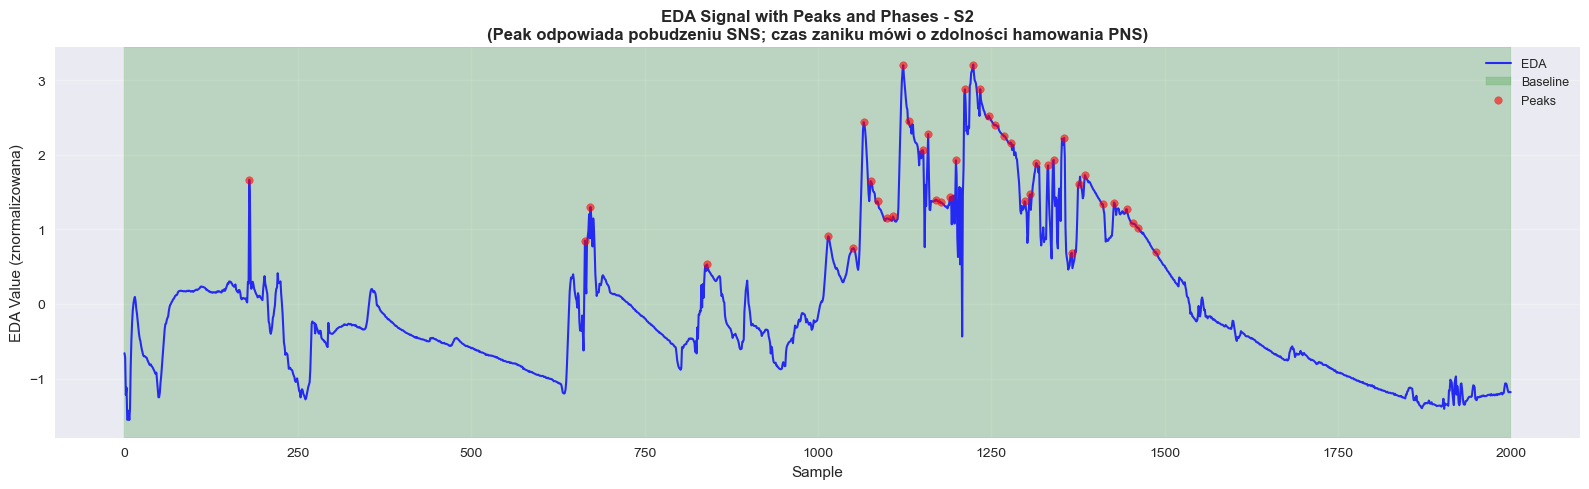

/var/folders/tv/dxnbn7ns00gc4hqrlzvj7s9r0000gp/T/ipykernel_89457/660643054.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p, lags, crit = kpss(series.dropna(), regression=regression, nlags="auto")
/var/folders/tv/dxnbn7ns00gc4hqrlzvj7s9r0000gp/T/ipykernel_89457/660643054.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p, lags, crit = kpss(series.dropna(), regression=regression, nlags="auto")
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided

   Transformacja dla ARIMA: differenced
   Szukam najlepszego modelu ARIMA...


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  

   Najlepszy model ARIMA(2, 0, 1), AIC: -2458.66
   ⏭️ Pomijam VAR (SKIP_VAR=True)

📊 ANALIZA BVP/HR dla S2
   RMSSD: 0.1318 s
   SDNN: 0.1146 s
   pNN50: 59.46%
   Mean HR: 72.82 bpm
   HR Acceleration (mean): 0.0211
   HR Acceleration (max): 0.0568
   HR Variability: 10.9617


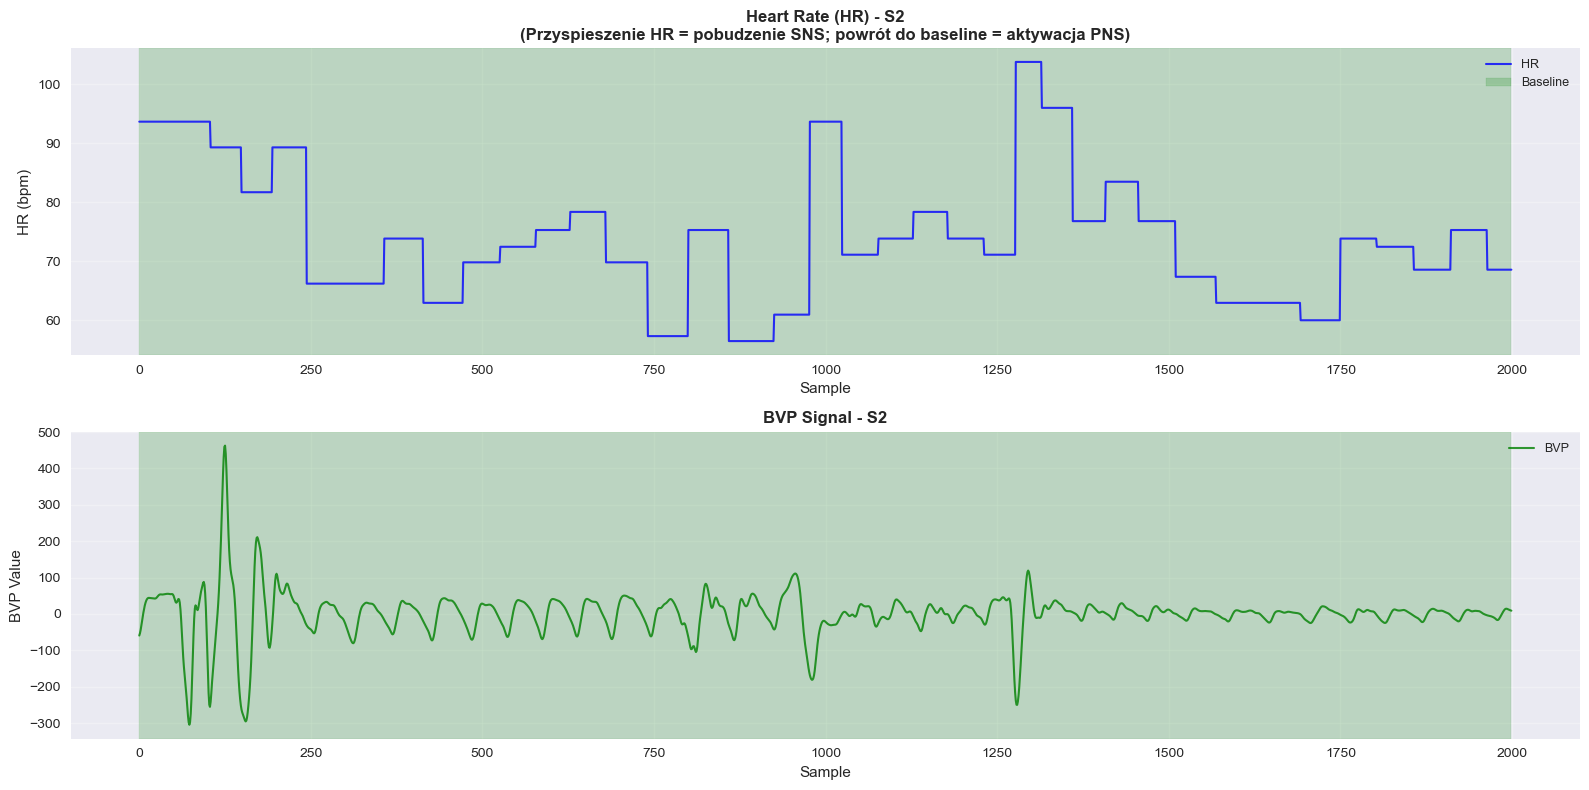


ANALIZA: S3

📊 ANALIZA EDA dla S3
   ✅ Uproszczony preprocessing: detrending + z-score normalizacja
      Średnia: -0.0000, Std: 1.5774
   Stacjonarność: non-stationary (both tests agree)


/var/folders/tv/dxnbn7ns00gc4hqrlzvj7s9r0000gp/T/ipykernel_89457/660643054.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p, lags, crit = kpss(series.dropna(), regression=regression, nlags="auto")


   📊 Baseline: -1.0548 (z 76 próbek)

   🔍 ANALIZA REAKCJI NA STRES:
      Stress start: indeks 1999 (z 2000 próbek)
      ⚠️ Stress start (1999) zbyt blisko końca sygnału

   📋 PODSUMOWANIE METRYK:
      • Liczba peaków: 66
      • Średni czas narastania: 4.76 s
      • Średni czas recovery: 3.70 s

   🎯 KLUCZOWE METRYKI TEMPERAMENTU (3 WYMIARY):
      1. Szybkość narastania: N/A
      2. Długość trwania pobudzenia: N/A
      3. Szybkość opadania: N/A


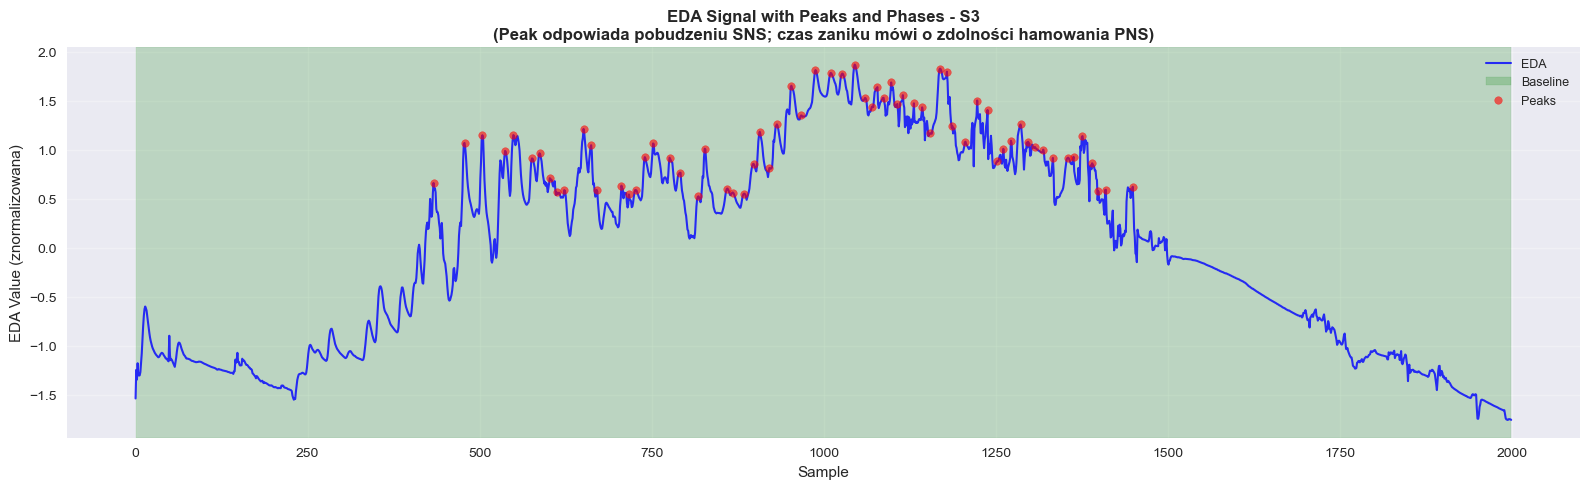

/var/folders/tv/dxnbn7ns00gc4hqrlzvj7s9r0000gp/T/ipykernel_89457/660643054.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p, lags, crit = kpss(series.dropna(), regression=regression, nlags="auto")
/var/folders/tv/dxnbn7ns00gc4hqrlzvj7s9r0000gp/T/ipykernel_89457/660643054.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p, lags, crit = kpss(series.dropna(), regression=regression, nlags="auto")
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided

   Transformacja dla ARIMA: differenced
   Szukam najlepszego modelu ARIMA...


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  

   Najlepszy model ARIMA(1, 0, 2), AIC: -5758.45
   ⏭️ Pomijam VAR (SKIP_VAR=True)

📊 ANALIZA BVP/HR dla S3
   RMSSD: 0.3046 s
   SDNN: 0.2343 s
   pNN50: 82.35%
   Mean HR: 69.45 bpm
   HR Acceleration (mean): 0.0342
   HR Acceleration (max): 0.1086
   HR Variability: 19.1616


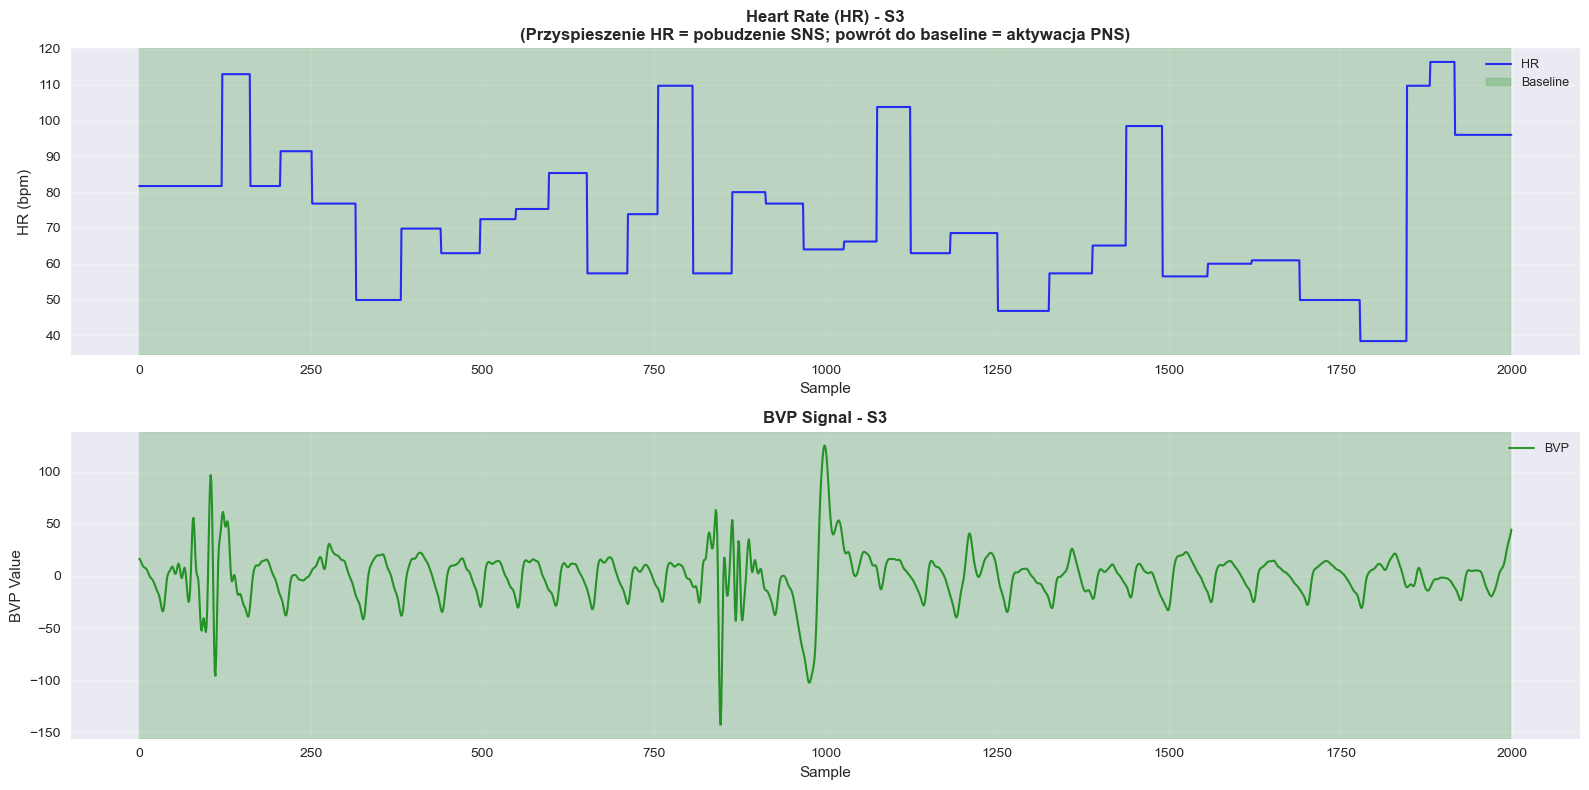


ANALIZA: S4

📊 ANALIZA EDA dla S4
   ✅ Uproszczony preprocessing: detrending + z-score normalizacja
      Średnia: 0.0000, Std: 0.1372


/var/folders/tv/dxnbn7ns00gc4hqrlzvj7s9r0000gp/T/ipykernel_89457/660643054.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p, lags, crit = kpss(series.dropna(), regression=regression, nlags="auto")


   Stacjonarność: inconclusive/mixed (ADF p=0.0018, KPSS p=0.0100)
   📊 Baseline: 0.9188 (z 77 próbek)

   🔍 ANALIZA REAKCJI NA STRES:
      Stress start: indeks 1999 (z 2000 próbek)
      ⚠️ Stress start (1999) zbyt blisko końca sygnału

   📋 PODSUMOWANIE METRYK:
      • Liczba peaków: 46
      • Średni czas narastania: 4.87 s
      • Średni czas recovery: 2.78 s

   🎯 KLUCZOWE METRYKI TEMPERAMENTU (3 WYMIARY):
      1. Szybkość narastania: N/A
      2. Długość trwania pobudzenia: N/A
      3. Szybkość opadania: N/A


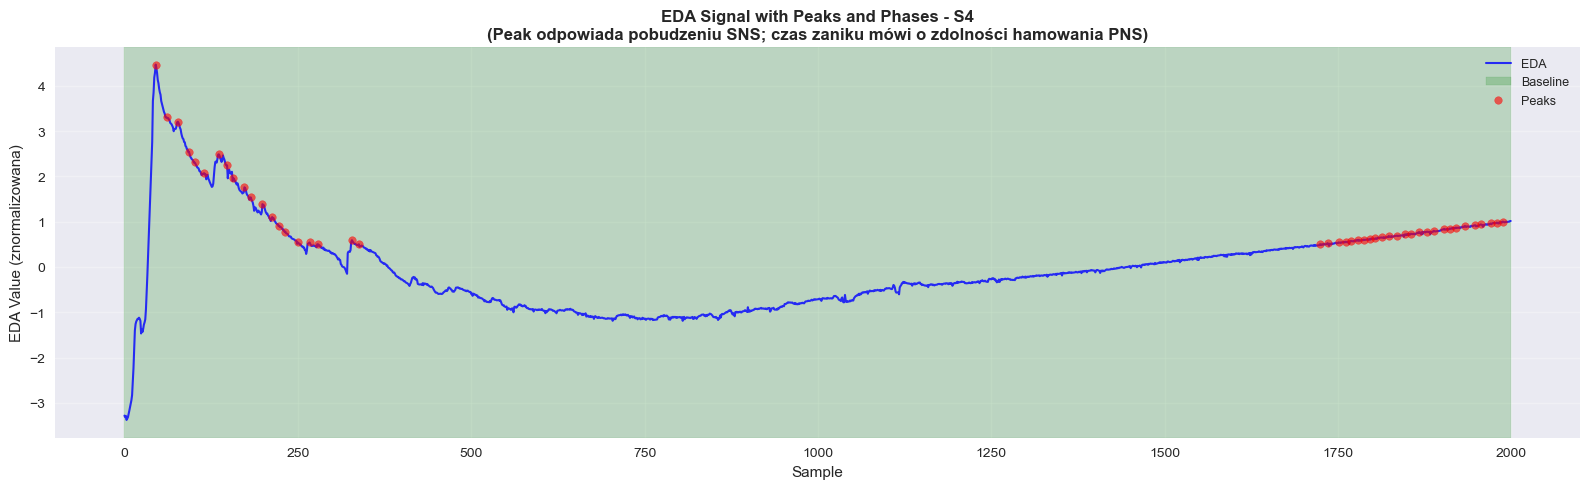

/var/folders/tv/dxnbn7ns00gc4hqrlzvj7s9r0000gp/T/ipykernel_89457/660643054.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p, lags, crit = kpss(series.dropna(), regression=regression, nlags="auto")
/var/folders/tv/dxnbn7ns00gc4hqrlzvj7s9r0000gp/T/ipykernel_89457/660643054.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p, lags, crit = kpss(series.dropna(), regression=regression, nlags="auto")
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided

   Transformacja dla ARIMA: differenced
   Szukam najlepszego modelu ARIMA...


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  

   Najlepszy model ARIMA(2, 0, 1), AIC: -7302.00
   ⏭️ Pomijam VAR (SKIP_VAR=True)

📊 ANALIZA BVP/HR dla S4
   RMSSD: 0.3952 s
   SDNN: 0.2724 s
   pNN50: 88.24%
   Mean HR: 66.85 bpm
   HR Acceleration (mean): 0.0390
   HR Acceleration (max): 0.1005
   HR Variability: 20.2542


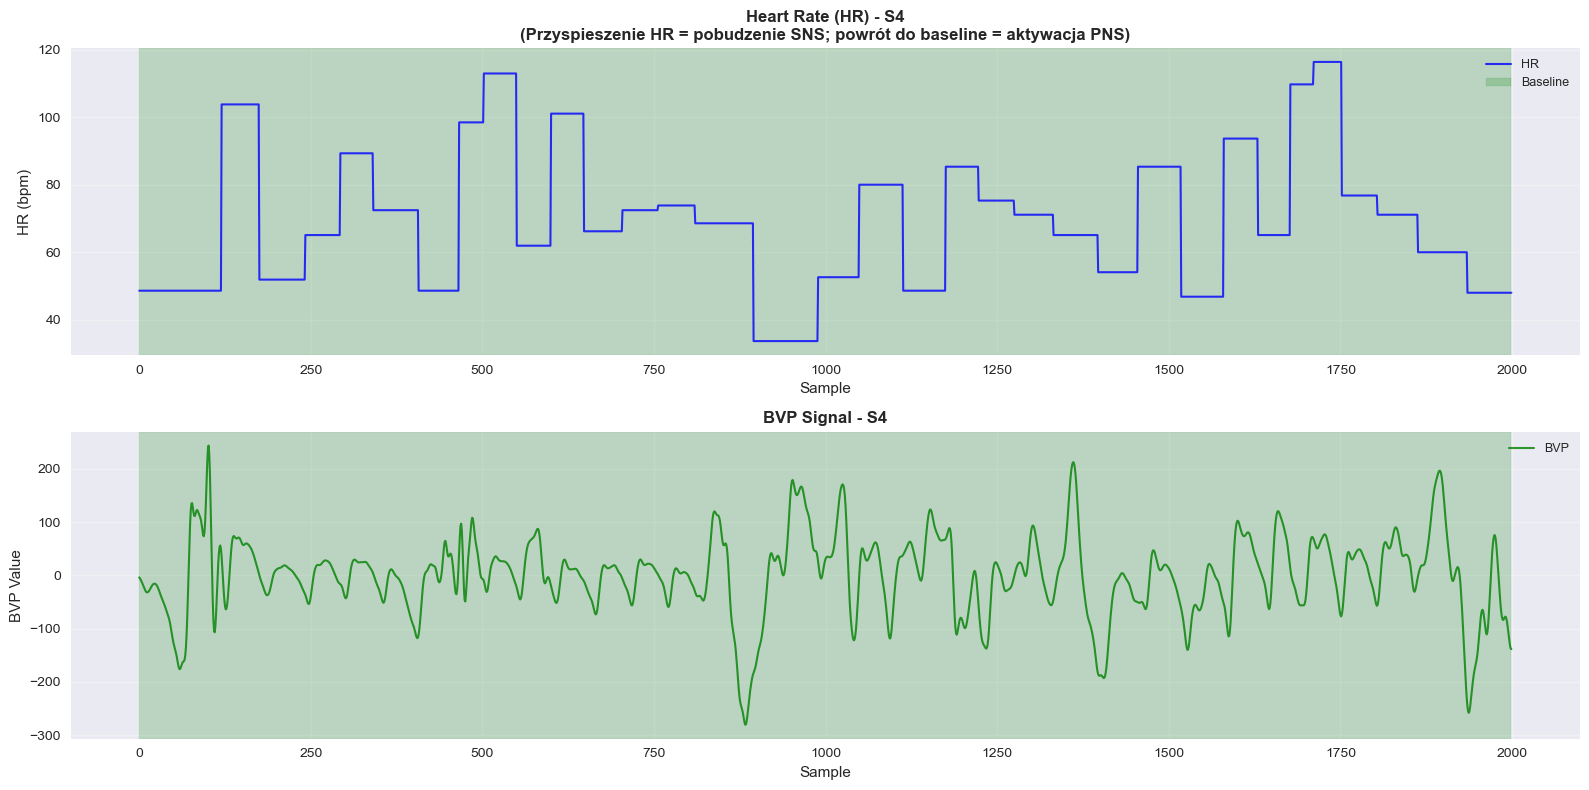


PODSUMOWANIE ANALIZY
✅ Przeanalizowano 3 osób


In [12]:
# ============================================================================
# KROK 8: ANALIZA DLA KAŻDEJ OSOBY OSOBNO
# ============================================================================

print("=" * 80)
print("KROK 8: ANALIZA DLA KAŻDEJ OSOBY")
print("=" * 80)

# Przechowuj wyniki dla wszystkich osób
all_results = {}

for subject in SELECTED_SUBJECTS:
    if subject not in subjects_data:
        print(f"\n⚠️ Brak danych dla {subject}")
        continue
    
    print(f"\n{'='*80}")
    print(f"ANALIZA: {subject}")
    print(f"{'='*80}")
    
    subject_results = {
        'subject': subject,
        'eda_metrics': {},
        'bvp_hr_metrics': {},
        'arima_models': {},
        'stationarity_tests': {}
    }
    
    data = subjects_data[subject]
    
    # ========== ANALIZA EDA ==========
    if 'eda' in data:
        print(f"\n📊 ANALIZA EDA dla {subject}")
        
        # UPROSZCZONY PREPROCESSING - tylko detrending i normalizacja
        eda_raw = pd.Series(data['eda'])
        
        # 1. Detrending (usuń trend liniowy)
        eda_detrended = pd.Series(spsignal.detrend(eda_raw.values), index=eda_raw.index if isinstance(eda_raw.index, pd.DatetimeIndex) else None)
        
        # 2. Normalizacja (z-score) - ułatwia porównanie między osobami
        eda_mean = eda_detrended.mean()
        eda_std = eda_detrended.std()
        if eda_std > 0:
            eda_series = (eda_detrended - eda_mean) / eda_std
        else:
            eda_series = eda_detrended - eda_mean
        
        print(f"   ✅ Uproszczony preprocessing: detrending + z-score normalizacja")
        print(f"      Średnia: {eda_mean:.4f}, Std: {eda_std:.4f}")
        
        # Testy stacjonarności
        adf_res = adf_test(eda_series)
        kpss_res = kpss_test(eda_series)
        interpretation = interpret_tests(adf_res, kpss_res, ALPHA)
        
        subject_results['stationarity_tests']['eda'] = {
            'adf_pvalue': adf_res['pvalue'],
            'kpss_pvalue': kpss_res['pvalue'],
            'interpretation': interpretation
        }
        
        print(f"   Stacjonarność: {interpretation}")
        
        # Reaktywność i recovery (podstawowe metryki)
        peaks_df, eda_summary = compute_eda_reactivity_recovery(
            eda_series, 
            sampling_hz=EDA_SAMPLING_HZ
        )
        
        # ========== KLUCZOWE METRYKI: 3 WYMIARY TEMPERAMENTU ==========
        # 1. SZYBKOŚĆ NARASTANIA (time-to-peak)
        # 2. DŁUGOŚĆ TRWANIA POBUDZENIA (duration of arousal)
        # 3. SZYBKOŚĆ OPADANIA (recovery speed)
        
        phase_indices = subjects_data[subject].get('phase_indices', {})
        eda_array = np.array(eda_series)
        
        key_metrics = {}
        
        # Pobierz oryginalny sygnał dla obliczenia skali
        try:
            data_orig = load_wesad_pickle(subject)
            eda_original = np.array(data_orig['signal']['wrist']['EDA'])
            original_length = len(eda_original)
        except:
            eda_original = np.array(subjects_data[subject].get('eda_original', subjects_data[subject]['eda']))
            original_length = len(eda_original)
        
        current_length = len(eda_array)
        scale_factor = current_length / original_length if original_length > 0 else 1.0
        
        # Oblicz baseline (średnia z fazy baseline)
        baseline_value = None
        if phase_indices and len(phase_indices.get('baseline', [])) > 0:
            baseline_idx = phase_indices['baseline']
            # Użyj pierwszych 1000 próbek baseline (przeskalowane)
            baseline_samples = min(1000, len(baseline_idx))
            baseline_start_orig = baseline_idx[0]
            baseline_end_orig = baseline_idx[baseline_samples - 1] if baseline_samples > 0 else baseline_idx[0]
            baseline_start = max(0, min(int(baseline_start_orig * scale_factor), len(eda_array) - 1))
            baseline_end = max(baseline_start + 10, min(int(baseline_end_orig * scale_factor), len(eda_array)))
            if baseline_end > baseline_start:
                baseline_value = np.mean(eda_array[baseline_start:baseline_end])
                print(f"   📊 Baseline: {baseline_value:.4f} (z {baseline_end - baseline_start} próbek)")
        
        # Analiza reakcji na stres
        if phase_indices and len(phase_indices.get('stress', [])) > 0 and baseline_value is not None:
            stress_start_orig = phase_indices['stress'][0]
            stress_start = max(0, min(int(stress_start_orig * scale_factor), len(eda_array) - 1))
            
            print(f"\n   🔍 ANALIZA REAKCJI NA STRES:")
            print(f"      Stress start: indeks {stress_start} (z {len(eda_array)} próbek)")
            
            if stress_start < len(eda_array) - 50:  # Musimy mieć miejsce na analizę
                # 1️⃣ SZYBKOŚĆ NARASTANIA (time-to-peak)
                time_to_peak, peak_idx, peak_amp = compute_time_to_peak(
                    eda_array, stress_start, EDA_SAMPLING_HZ
                )
                
                if not np.isnan(time_to_peak) and peak_idx is not None and peak_idx < len(eda_array):
                    key_metrics['szybkosc_narastania_s'] = time_to_peak
                    key_metrics['peak_amplitude'] = peak_amp
                    key_metrics['peak_index'] = peak_idx
                    
                    print(f"      ✅ 1. Szybkość narastania: {time_to_peak:.2f}s")
                    print(f"         Peak: indeks {peak_idx}, amplituda względem baseline: {peak_amp:.4f}")
                    
                    # 2️⃣ DŁUGOŚĆ TRWANIA POBUDZENIA (czas od peaku do powrotu do baseline)
                    # Szukamy gdzie sygnał wraca do baseline (tolerancja 10% od baseline)
                    baseline_tolerance = abs(baseline_value) * 0.1
                    arousal_duration = np.nan
                    
                    for i in range(peak_idx, min(peak_idx + int(120 * EDA_SAMPLING_HZ), len(eda_array))):
                        if abs(eda_array[i] - baseline_value) <= baseline_tolerance:
                            arousal_duration = (i - peak_idx) / EDA_SAMPLING_HZ
                            break
                    
                    if np.isnan(arousal_duration):
                        # Jeśli nie wrócił do baseline, użyj czasu do 50% wartości
                        half_value = baseline_value + 0.5 * (eda_array[peak_idx] - baseline_value)
                        for i in range(peak_idx, min(peak_idx + int(120 * EDA_SAMPLING_HZ), len(eda_array))):
                            if eda_array[i] <= half_value:
                                arousal_duration = (i - peak_idx) / EDA_SAMPLING_HZ
                                break
                    
                    if not np.isnan(arousal_duration):
                        key_metrics['dlugosc_trwania_pobudzenia_s'] = arousal_duration
                        print(f"      ✅ 2. Długość trwania pobudzenia: {arousal_duration:.2f}s")
                    
                    # 3️⃣ SZYBKOŚĆ OPADANIA (recovery speed)
                    if peak_idx < len(eda_array) - 1:
                        recovery_time, recovery_slope = compute_recovery_speed(
                            eda_array, peak_idx, baseline_value, EDA_SAMPLING_HZ
                        )
                        if not np.isnan(recovery_time):
                            key_metrics['szybkosc_opadania_s'] = recovery_time
                            key_metrics['recovery_slope'] = recovery_slope
                            print(f"      ✅ 3. Szybkość opadania: {recovery_time:.2f}s (slope: {recovery_slope:.4f})")
                else:
                    print(f"      ❌ Nie udało się obliczyć metryk (time_to_peak={time_to_peak}, peak_idx={peak_idx})")
            else:
                print(f"      ⚠️ Stress start ({stress_start}) zbyt blisko końca sygnału")
        else:
            print(f"   ⚠️ Brak danych stress lub baseline dla {subject}")
        
        # Połącz wszystkie metryki EDA - tylko kluczowe 3 metryki + podstawowe
        subject_results['eda_metrics'] = {
            **eda_summary,  # Podstawowe metryki (liczba peaków, średnie czasy, etc.)
            **key_metrics   # Kluczowe 3 metryki temperamentu
        }
        
        print(f"\n   📋 PODSUMOWANIE METRYK:")
        print(f"      • Liczba peaków: {eda_summary['n_peaks']}")
        print(f"      • Średni czas narastania: {eda_summary['mean_rise_time_s']:.2f} s")
        print(f"      • Średni czas recovery: {eda_summary['mean_recovery_time_s']:.2f} s")
        
        # Wyświetl kluczowe 3 metryki temperamentu
        print(f"\n   🎯 KLUCZOWE METRYKI TEMPERAMENTU (3 WYMIARY):")
        if 'szybkosc_narastania_s' in key_metrics:
            print(f"      1. Szybkość narastania: {key_metrics['szybkosc_narastania_s']:.2f} s")
        else:
            print(f"      1. Szybkość narastania: N/A")
        
        if 'dlugosc_trwania_pobudzenia_s' in key_metrics:
            print(f"      2. Długość trwania pobudzenia: {key_metrics['dlugosc_trwania_pobudzenia_s']:.2f} s")
        else:
            print(f"      2. Długość trwania pobudzenia: N/A")
        
        if 'szybkosc_opadania_s' in key_metrics:
            print(f"      3. Szybkość opadania: {key_metrics['szybkosc_opadania_s']:.2f} s")
        else:
            print(f"      3. Szybkość opadania: N/A")
        
        # Wizualizacja EDA z peakami i fazami
        if len(peaks_df) > 0:
            fig, ax = plt.subplots(figsize=(16, 5))
            
            # Ogranicz do pierwszych 2000 próbek dla czytelności
            max_samples = min(2000, len(eda_series))
            x_vals = range(max_samples)
            y_vals = eda_series.values[:max_samples]
            
            ax.plot(x_vals, y_vals, label='EDA', linewidth=1.5, alpha=0.8, color='blue')
            
            # Zaznacz fazy (jeśli dostępne)
            phase_indices_viz = subjects_data[subject].get('phase_indices', {})
            if phase_indices_viz:
                # Przeskaluj indeksy jeśli sygnał został ograniczony
                eda_original_len = len(subjects_data[subject]['eda'])
                if eda_original_len > max_samples:
                    scale_factor = max_samples / eda_original_len
                else:
                    scale_factor = 1.0
                # Baseline
                baseline_idx = phase_indices_viz.get('baseline', [])
                baseline_in_range = [i for i in baseline_idx if i < max_samples]
                if len(baseline_in_range) > 0:
                    ax.axvspan(min(baseline_in_range), max(baseline_in_range), 
                              alpha=0.2, color='green', label='Baseline')
                
                # Stress
                stress_idx = phase_indices_viz.get('stress', [])
                stress_in_range = [i for i in stress_idx if i < max_samples]
                if len(stress_in_range) > 0:
                    ax.axvspan(min(stress_in_range), max(stress_in_range), 
                              alpha=0.2, color='red', label='Stress')
                
                # Amusement
                amusement_idx = phase_indices_viz.get('amusement', [])
                amusement_in_range = [i for i in amusement_idx if i < max_samples]
                if len(amusement_in_range) > 0:
                    ax.axvspan(min(amusement_in_range), max(amusement_in_range), 
                              alpha=0.2, color='orange', label='Amusement')
            
            # Zaznacz piki
            peak_indices = peaks_df['peak_index'].values
            peak_indices = peak_indices[peak_indices < max_samples]
            if len(peak_indices) > 0:
                ax.scatter(peak_indices, eda_series.values[peak_indices], 
                          color='red', s=30, zorder=5, label='Peaks', alpha=0.6)
            
            ax.set_title(f'EDA Signal with Peaks and Phases - {subject}\n(Peak odpowiada pobudzeniu SNS; czas zaniku mówi o zdolności hamowania PNS)', 
                        fontsize=12, fontweight='bold')
            ax.set_xlabel('Sample')
            ax.set_ylabel('EDA Value (znormalizowana)')
            ax.legend(loc='upper right', fontsize=9)
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        
        # Przygotuj do ARIMA (uczyń stacjonarnym)
        eda_stationary, transform_type = make_stationary(eda_series, ALPHA)
        print(f"   Transformacja dla ARIMA: {transform_type}")
        
        # ARIMA grid search
        if not SKIP_ARIMA and len(eda_stationary) > 10:
            print(f"   Szukam najlepszego modelu ARIMA...")
            try:
                order, model_res = simple_arima_grid_search(eda_stationary, p_max=2, d_max=1, q_max=2)  # Zmniejszone zakresy
                
                if order is not None:
                    subject_results['arima_models']['eda'] = {
                        'order': order,
                        'aic': model_res.aic if model_res else np.nan
                    }
                    print(f"   Najlepszy model ARIMA{order}, AIC: {model_res.aic:.2f}")
                    
                    # Forecast (pomijamy wizualizację dla szybkości)
                    # forecast_and_plot(model_res, eda_stationary, 
                    #                 steps=FORECAST_STEPS, 
                    #                 title="EDA Forecast",
                    #                 subject=subject,
                    #                 signal="EDA")
            except Exception as e:
                print(f"   ⚠️ ARIMA failed: {e}")
        elif SKIP_ARIMA:
            print(f"   ⏭️ Pomijam ARIMA (SKIP_ARIMA=True)")
        
        # VAR modelowanie (jeśli mamy wiele sygnałów)
        if not SKIP_VAR and 'bvp' in data and 'temp' in data:
            print(f"\n   🔄 VAR Modelowanie (EDA + BVP + TEMP)...")
            try:
                # Przygotuj sygnały do wspólnej częstotliwości
                signals_dict = {
                    'eda': (data['eda'], EDA_SAMPLING_HZ),
                    'bvp': (data['bvp'], BVP_SAMPLING_HZ),
                    'temp': (data['temp'], TEMP_SAMPLING_HZ)
                }
                
                interpolated = interpolate_to_common_fs(signals_dict, target_fs=4.0)
                
                # Stwórz DataFrame dla VAR
                var_df = pd.DataFrame(interpolated)
                
                # Uczyń stacjonarnym
                var_df_stationary = var_df.copy()
                for col in var_df_stationary.columns:
                    stationary, _ = make_stationary(var_df_stationary[col], ALPHA)
                    var_df_stationary[col] = stationary
                
                var_df_stationary = var_df_stationary.dropna()
                
                if len(var_df_stationary) > 50:
                    # Fit VAR model
                    var_model = VAR(var_df_stationary)
                    var_result = var_model.fit(maxlags=5, ic='aic')
                    
                    subject_results['var_model'] = {
                        'lags': var_result.k_ar,
                        'aic': var_result.aic,
                        'bic': var_result.bic
                    }
                    print(f"   VAR model: {var_result.k_ar} lags, AIC: {var_result.aic:.2f}")
            except Exception as e:
                print(f"   ⚠️ VAR modeling failed: {e}")
        elif SKIP_VAR:
            print(f"   ⏭️ Pomijam VAR (SKIP_VAR=True)")
    
    # ========== ANALIZA BVP/HR ==========
    if 'bvp' in data:
        print(f"\n📊 ANALIZA BVP/HR dla {subject}")
        bvp_series = pd.Series(data['bvp'])
        
        # Oblicz HR z BVP
        hr_series, rr_intervals = compute_hr_from_bvp(bvp_series, sampling_hz=BVP_SAMPLING_HZ)
        
        if hr_series is not None and len(hr_series) > 0:
            # HRV metryki (czasowe)
            hrv_metrics = compute_hrv_metrics(rr_intervals)
            
            if hrv_metrics:
                subject_results['bvp_hr_metrics']['hrv'] = hrv_metrics
                print(f"   RMSSD: {hrv_metrics['rmssd']:.4f} s")
                print(f"   SDNN: {hrv_metrics['sdnn']:.4f} s")
                print(f"   pNN50: {hrv_metrics.get('pnn50', hrv_metrics.get('pNN50', np.nan)):.2f}%")
                print(f"   Mean HR: {hrv_metrics['mean_hr']:.2f} bpm")
            
            # Analiza spektralna HRV (LF/HF)
            spectral_hrv = compute_spectral_hrv(rr_intervals, sampling_hz=1.0)
            if spectral_hrv:
                subject_results['bvp_hr_metrics']['spectral'] = {
                    'lf_power': spectral_hrv['lf_power'],
                    'hf_power': spectral_hrv['hf_power'],
                    'lf_nu': spectral_hrv['lf_nu'],
                    'hf_nu': spectral_hrv['hf_nu'],
                    'lf_hf_ratio': spectral_hrv['lf_hf_ratio']
                }
                print(f"   LF/HF Ratio: {spectral_hrv['lf_hf_ratio']:.4f}")
                print(f"   LF (nu): {spectral_hrv['lf_nu']:.2f}%")
                print(f"   HF (nu): {spectral_hrv['hf_nu']:.2f}%")
            
            # Przyspieszenie HR
            hr_accel = compute_hr_acceleration(hr_series, sampling_hz=BVP_SAMPLING_HZ)
            subject_results['bvp_hr_metrics']['acceleration'] = hr_accel
            print(f"   HR Acceleration (mean): {hr_accel['hr_acceleration_mean']:.4f}")
            print(f"   HR Acceleration (max): {hr_accel['hr_acceleration_max']:.4f}")
            print(f"   HR Variability: {hr_accel['hr_variability']:.4f}")
            
            # Wizualizacja HR z fazami
            fig, axes = plt.subplots(2, 1, figsize=(16, 8))
            
            max_samples_hr = min(2000, len(hr_series))
            x_vals_hr = range(max_samples_hr)
            
            # HR w czasie
            axes[0].plot(x_vals_hr, hr_series.values[:max_samples_hr], 
                        linewidth=1.5, alpha=0.8, color='blue', label='HR')
            
            # Zaznacz fazy
            phase_indices_viz = subjects_data[subject].get('phase_indices', {})
            if phase_indices_viz:
                # Przeskaluj indeksy dla HR (BVP ma inną częstotliwość próbkowania)
                bvp_original_len = len(subjects_data[subject]['bvp'])
                if bvp_original_len > max_samples_hr:
                    scale_factor_hr = max_samples_hr / bvp_original_len
                else:
                    scale_factor_hr = 1.0
                
                # Baseline
                baseline_idx = phase_indices_viz.get('baseline', [])
                if len(baseline_idx) > 0:
                    baseline_scaled = [int(i * scale_factor_hr) for i in baseline_idx if int(i * scale_factor_hr) < max_samples_hr]
                    if len(baseline_scaled) > 0:
                        axes[0].axvspan(min(baseline_scaled), max(baseline_scaled), 
                                        alpha=0.2, color='green', label='Baseline')
                
                # Stress
                stress_idx = phase_indices_viz.get('stress', [])
                if len(stress_idx) > 0:
                    stress_scaled = [int(i * scale_factor_hr) for i in stress_idx if int(i * scale_factor_hr) < max_samples_hr]
                    if len(stress_scaled) > 0:
                        axes[0].axvspan(min(stress_scaled), max(stress_scaled), 
                                        alpha=0.2, color='red', label='Stress')
                
                # Amusement
                amusement_idx = phase_indices_viz.get('amusement', [])
                if len(amusement_idx) > 0:
                    amusement_scaled = [int(i * scale_factor_hr) for i in amusement_idx if int(i * scale_factor_hr) < max_samples_hr]
                    if len(amusement_scaled) > 0:
                        axes[0].axvspan(min(amusement_scaled), max(amusement_scaled), 
                                        alpha=0.2, color='orange', label='Amusement')
            
            axes[0].set_title(f'Heart Rate (HR) - {subject}\n(Przyspieszenie HR = pobudzenie SNS; powrót do baseline = aktywacja PNS)', 
                             fontsize=12, fontweight='bold')
            axes[0].set_xlabel('Sample')
            axes[0].set_ylabel('HR (bpm)')
            axes[0].legend(loc='upper right', fontsize=9)
            axes[0].grid(True, alpha=0.3)
            
            # BVP sygnał
            max_samples_bvp = min(2000, len(bvp_series))
            x_vals_bvp = range(max_samples_bvp)
            axes[1].plot(x_vals_bvp, bvp_series.values[:max_samples_bvp], 
                        linewidth=1.5, alpha=0.8, color='green', label='BVP')
            
            # Zaznacz fazy dla BVP
            if phase_indices_viz:
                if bvp_original_len > max_samples_bvp:
                    scale_factor_bvp = max_samples_bvp / bvp_original_len
                else:
                    scale_factor_bvp = 1.0
                
                baseline_scaled_bvp = [int(i * scale_factor_bvp) for i in baseline_idx if int(i * scale_factor_bvp) < max_samples_bvp]
                if len(baseline_scaled_bvp) > 0:
                    axes[1].axvspan(min(baseline_scaled_bvp), max(baseline_scaled_bvp), 
                                    alpha=0.2, color='green')
                
                stress_scaled_bvp = [int(i * scale_factor_bvp) for i in stress_idx if int(i * scale_factor_bvp) < max_samples_bvp]
                if len(stress_scaled_bvp) > 0:
                    axes[1].axvspan(min(stress_scaled_bvp), max(stress_scaled_bvp), 
                                    alpha=0.2, color='red')
                
                amusement_scaled_bvp = [int(i * scale_factor_bvp) for i in amusement_idx if int(i * scale_factor_bvp) < max_samples_bvp]
                if len(amusement_scaled_bvp) > 0:
                    axes[1].axvspan(min(amusement_scaled_bvp), max(amusement_scaled_bvp), 
                                    alpha=0.2, color='orange')
            
            axes[1].set_title(f'BVP Signal - {subject}', fontsize=12, fontweight='bold')
            axes[1].set_xlabel('Sample')
            axes[1].set_ylabel('BVP Value')
            axes[1].legend(loc='upper right', fontsize=9)
            axes[1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
    
    all_results[subject] = subject_results

print(f"\n{'='*80}")
print("PODSUMOWANIE ANALIZY")
print(f"{'='*80}")
print(f"✅ Przeanalizowano {len(all_results)} osób")


## KROK 9A: Obliczanie wymiarów temperamentu Strelaua


In [16]:
# ============================================================================
# KROK 9A: OBLICZANIE WYMIARÓW TEMPERAMENTU STRELAUA
# ============================================================================

def compute_strelau_dimensions(eda_metrics, bvp_metrics):
    """
    Oblicza wymiary temperamentu Strelaua na podstawie metryk EDA i BVP/HR.
    
    Wymiary Strelaua:
    1. Żywość (vigor/briskness) - szybkość reakcji na bodźce
    2. Perseweratywność - tendencja do podtrzymywania reakcji
    3. Aktywność - częstość i intensywność działań
    4. Reaktywność emocjonalna - wrażliwość układu nerwowego
    5. Wrażliwość sensoryczna - reakcja na subtelne bodźce
    6. Rytmiczność/regularność - powtarzalność reakcji
    7. Niestałość/niestabilność - chaotyczność zmian
    
    Returns:
        dimensions: słownik z wymiarami (wartości znormalizowane 0-1, gdzie wyższe = wyższy wymiar)
    """
    dimensions = {}
    
    # 1. ŻYWOŚĆ (vigor/briskness) - time-to-peak
    # Szybki pik = wysoka żywość
    time_to_peak = eda_metrics.get('time_to_peak_stress_s', np.nan)
    mean_rise_time = eda_metrics.get('mean_rise_time_s', np.nan)
    
    if not np.isnan(time_to_peak):
        # Im krótszy czas, tym wyższa żywość (odwrotna relacja)
        # Normalizacja: < 5s = wysoka (1.0), > 15s = niska (0.0)
        vigor = max(0, min(1, 1 - (time_to_peak - 5) / 10)) if time_to_peak >= 5 else 1.0
    elif not np.isnan(mean_rise_time):
        vigor = max(0, min(1, 1 - (mean_rise_time - 3) / 10)) if mean_rise_time >= 3 else 1.0
    else:
        vigor = np.nan
    
    dimensions['zywość_vigor'] = vigor
    
    # 2. PERSEWERATYWNOSĆ - czas wygasania pobudzenia
    # Długie wygasanie = wysoka perseweratywność
    recovery_time = eda_metrics.get('recovery_time_stress_s', np.nan)
    mean_recovery_time = eda_metrics.get('mean_recovery_time_s', np.nan)
    
    if not np.isnan(recovery_time):
        # Im dłuższy czas, tym wyższa perseweratywność
        # Normalizacja: < 10s = niska (0.0), > 40s = wysoka (1.0)
        perseveration = max(0, min(1, (recovery_time - 10) / 30)) if recovery_time >= 10 else 0.0
    elif not np.isnan(mean_recovery_time):
        perseveration = max(0, min(1, (mean_recovery_time - 10) / 30)) if mean_recovery_time >= 10 else 0.0
    else:
        perseveration = np.nan
    
    dimensions['perseweratywność'] = perseveration
    
    # 3. AKTYWNOŚĆ - zakres reakcji / amplituda sygnału
    # Mocny peak = wysoka aktywność
    peak_amplitude = eda_metrics.get('peak_amplitude_stress', np.nan)
    reaction_range = eda_metrics.get('reaction_range', np.nan)
    mean_peak_amplitude = eda_metrics.get('mean_peak_amplitude', np.nan)
    
    if not np.isnan(peak_amplitude):
        # Normalizacja względem mediany (zakładamy medianę ~0.03)
        activity = min(1.0, peak_amplitude / 0.1) if peak_amplitude > 0 else 0.0
    elif not np.isnan(reaction_range):
        activity = min(1.0, reaction_range / 0.1) if reaction_range > 0 else 0.0
    elif not np.isnan(mean_peak_amplitude):
        activity = min(1.0, mean_peak_amplitude / 0.1) if mean_peak_amplitude > 0 else 0.0
    else:
        activity = np.nan
    
    dimensions['aktywność'] = activity
    
    # 4. REAKTYWNOŚĆ EMOCJONALNA - szybkość i amplituda reakcji na małe stresory
    # Kombinacja żywości i aktywności
    sensitivity = eda_metrics.get('sensitivity', np.nan)
    
    if not np.isnan(sensitivity):
        # Normalizacja: < 1 = niska (0.0), > 3 = wysoka (1.0)
        emotional_reactivity = max(0, min(1, (sensitivity - 1) / 2)) if sensitivity >= 1 else 0.0
    else:
        # Fallback: średnia z żywości i aktywności
        if not np.isnan(vigor) and not np.isnan(activity):
            emotional_reactivity = (vigor + activity) / 2
        else:
            emotional_reactivity = np.nan
    
    dimensions['reaktywność_emocjonalna'] = emotional_reactivity
    
    # 5. WRAŻLIWOŚĆ SENSORYCZNA - mikro-oscylacje, fluktuacje baseline'u
    # Większe wahania = wyższa wrażliwość
    reaction_variability = eda_metrics.get('reaction_variability', np.nan)
    phasic_activity = eda_metrics.get('phasic_activity', np.nan)
    
    if not np.isnan(reaction_variability):
        # Normalizacja względem mediany
        sensory_sensitivity = min(1.0, reaction_variability / 0.05) if reaction_variability > 0 else 0.0
    elif not np.isnan(phasic_activity):
        sensory_sensitivity = min(1.0, phasic_activity / 0.01) if phasic_activity > 0 else 0.0
    else:
        sensory_sensitivity = np.nan
    
    dimensions['wrażliwość_sensoryczna'] = sensory_sensitivity
    
    # 6. RYTMICZNOŚĆ/REGULARNOŚĆ - autocorrelation lub spektralna gęstość mocy
    # Wyższa autocorrelation = wyższa rytmiczność
    autocorr_lag1 = eda_metrics.get('autocorr_max_lag1', np.nan)
    
    if not np.isnan(autocorr_lag1):
        # Autocorrelation jest już w zakresie -1 do 1, normalizujemy do 0-1
        rhythmicity = (autocorr_lag1 + 1) / 2 if autocorr_lag1 >= -1 else 0.0
    else:
        rhythmicity = np.nan
    
    dimensions['rytmiczność_regularność'] = rhythmicity
    
    # 7. NIESAŁOŚĆ/NIESTABILNOŚĆ - Lyapunov exponent
    # Większe wartości = wyższa niestabilność
    lyapunov = eda_metrics.get('lyapunov_exponent', np.nan)
    
    if not np.isnan(lyapunov):
        # Normalizacja: < 0.01 = niska (0.0), > 0.1 = wysoka (1.0)
        instability = max(0, min(1, (lyapunov - 0.01) / 0.09)) if lyapunov >= 0.01 else 0.0
    else:
        instability = np.nan
    
    dimensions['niestałość_niestabilność'] = instability
    
    return dimensions

print("✅ Funkcja obliczania wymiarów Strelaua zdefiniowana")


✅ Funkcja obliczania wymiarów Strelaua zdefiniowana


KROK 9: PORÓWNANIE PROFILI I WNIOSKI

📊 PORÓWNANIE METRYK - 3 WYMIARY TEMPERAMENTU:
subject  szybkosc_narastania_s  dlugosc_trwania_pobudzenia_s  szybkosc_opadania_s  amplituda temperament
     S2                    NaN                           NaN                  NaN        NaN BRAK DANYCH
     S3                    NaN                           NaN                  NaN        NaN BRAK DANYCH
     S4                    NaN                           NaN                  NaN        NaN BRAK DANYCH

📋 INTERPRETACJA WEDŁUG STRELAUA (TABELA):

Osoba time-to-peak czas zaniku amplituda interpretacja wg Strelaua                                        opis
   S2          N/A         N/A       N/A               BRAK DANYCH Nie można określić - brak kluczowych metryk
   S3          N/A         N/A       N/A               BRAK DANYCH Nie można określić - brak kluczowych metryk
   S4          N/A         N/A       N/A               BRAK DANYCH Nie można określić - brak kluczowych metryk


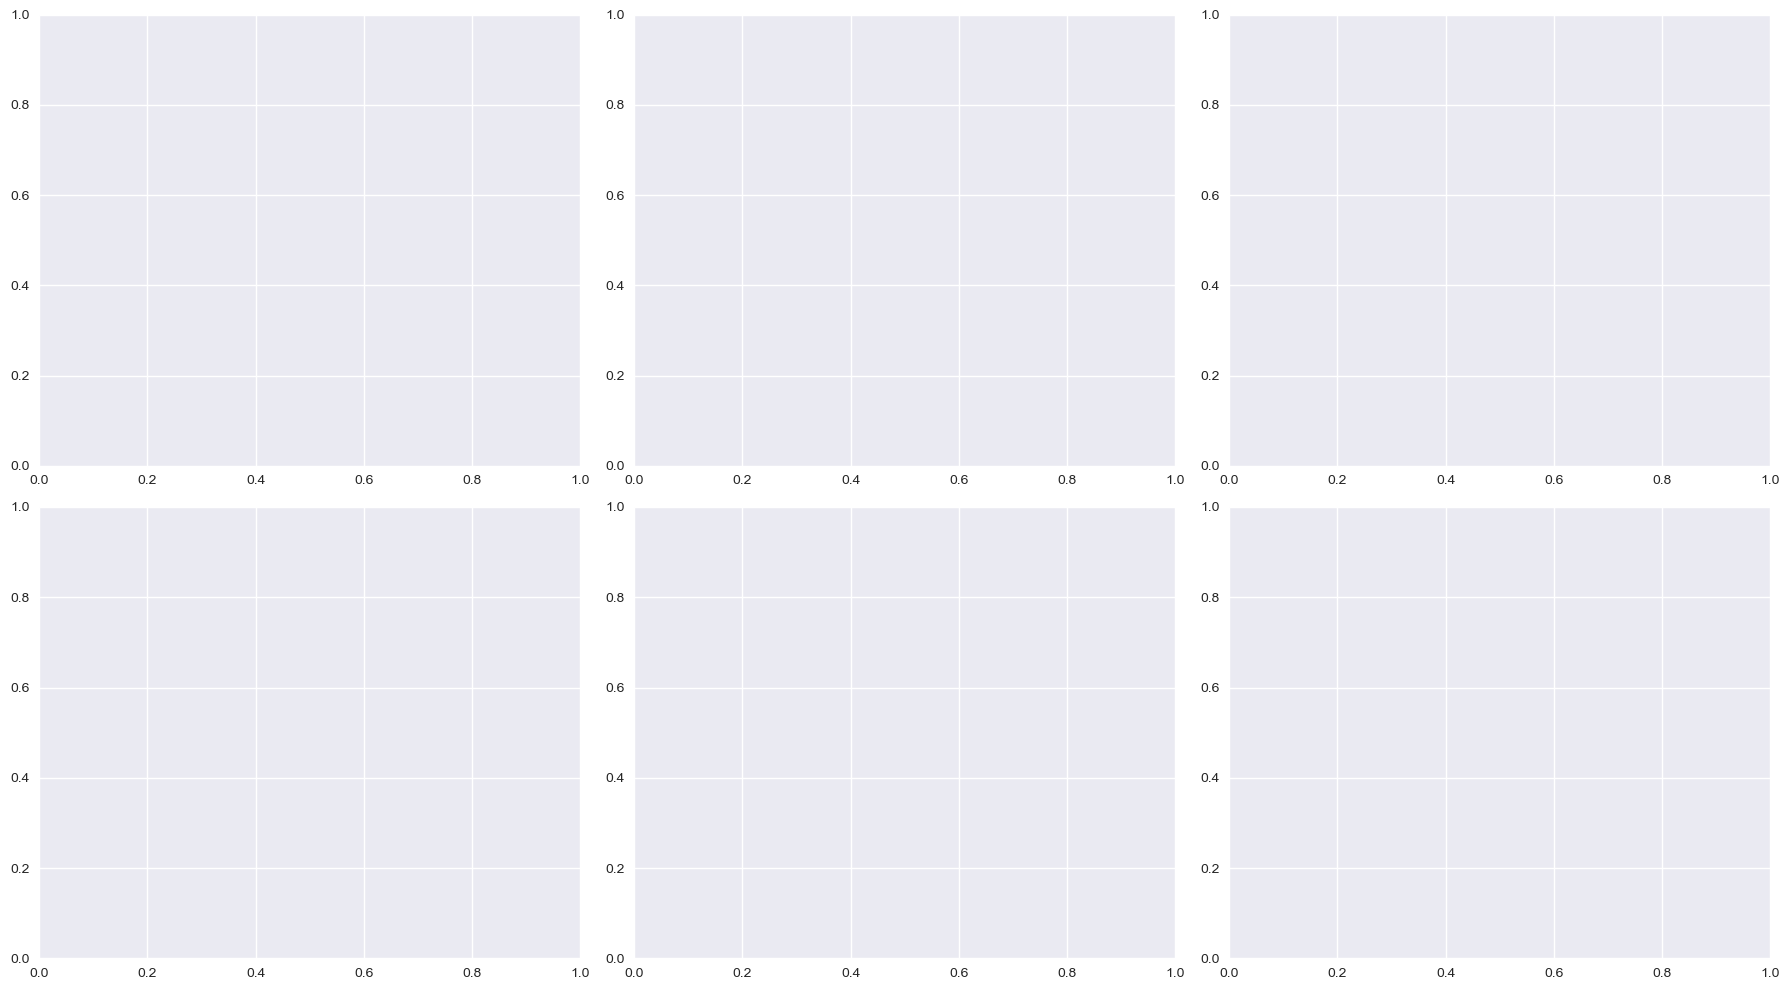


SZCZEGÓŁOWE PROFILE Z WYMIARAMI STRELAUA

👤 OSOBA: S2

📊 KLUCZOWE METRYKI (3 WYMIARY TEMPERAMENTU):
   1. Szybkość narastania: N/A
   2. Długość trwania pobudzenia: N/A
   3. Szybkość opadania: N/A
   • Amplituda reakcji: N/A

⚠️ Brak kompletnych danych do interpretacji temperamentu

👤 OSOBA: S3

📊 KLUCZOWE METRYKI (3 WYMIARY TEMPERAMENTU):
   1. Szybkość narastania: N/A
   2. Długość trwania pobudzenia: N/A
   3. Szybkość opadania: N/A
   • Amplituda reakcji: N/A

⚠️ Brak kompletnych danych do interpretacji temperamentu

👤 OSOBA: S4

📊 KLUCZOWE METRYKI (3 WYMIARY TEMPERAMENTU):
   1. Szybkość narastania: N/A
   2. Długość trwania pobudzenia: N/A
   3. Szybkość opadania: N/A
   • Amplituda reakcji: N/A

⚠️ Brak kompletnych danych do interpretacji temperamentu

✅ Analiza zakończona!


In [19]:
# ============================================================================
# KROK 9: PORÓWNANIE PROFILI I WNIOSKI
# ============================================================================

print("=" * 80)
print("KROK 9: PORÓWNANIE PROFILI I WNIOSKI")
print("=" * 80)

# Stwórz DataFrame z porównaniem - KLUCZOWE METRYKI DLA INTERPRETACJI TEMPERAMENTU
comparison_data = []

for subject, results in all_results.items():
    eda_metrics = results.get('eda_metrics', {})
    bvp_metrics = results.get('bvp_hr_metrics', {})
    
    # Oblicz wymiary Strelaua
    strelau_dims = compute_strelau_dimensions(eda_metrics, bvp_metrics)
    
    # Kluczowe 3 metryki temperamentu (nowe nazwy)
    szybkosc_narastania = eda_metrics.get('szybkosc_narastania_s', np.nan)
    dlugosc_trwania = eda_metrics.get('dlugosc_trwania_pobudzenia_s', np.nan)
    szybkosc_opadania = eda_metrics.get('szybkosc_opadania_s', np.nan)
    amplituda = eda_metrics.get('peak_amplitude', np.nan)
    
    row = {
        'subject': subject,
        # KLUCZOWE 3 METRYKI TEMPERAMENTU
        'szybkosc_narastania_s': szybkosc_narastania,
        'dlugosc_trwania_pobudzenia_s': dlugosc_trwania,
        'szybkosc_opadania_s': szybkosc_opadania,
        'amplituda': amplituda,
    }
    
    # Interpretacja temperamentu na podstawie 3 metryk
    if not np.isnan(szybkosc_narastania) and not np.isnan(dlugosc_trwania) and not np.isnan(szybkosc_opadania):
        # Progi (można dostosować)
        szybki_narost = szybkosc_narastania < 10  # < 10s = szybki
        dlugie_trwanie = dlugosc_trwania > 30     # > 30s = długie
        szybkie_opadanie = szybkosc_opadania < 20  # < 20s = szybkie
        
        # Klasyfikacja temperamentu
        if szybki_narost and szybkie_opadanie and not dlugie_trwanie:
            temperament = "POBUDLIWY - SZYBKI"
            opis = "Szybko reaguje, szybko wraca do baseline"
        elif szybki_narost and dlugie_trwanie and not szybkie_opadanie:
            temperament = "POBUDLIWY - DŁUGO UTRZYMUJĄCY"
            opis = "Szybko reaguje, długo utrzymuje pobudzenie, wolno wraca"
        elif not szybki_narost and dlugie_trwanie:
            temperament = "STABILNY - WOLNY"
            opis = "Wolno reaguje, długo utrzymuje pobudzenie"
        elif szybki_narost and szybkie_opadanie and dlugie_trwanie:
            temperament = "POBUDLIWY - INTENSYWNY"
            opis = "Szybko reaguje, długo utrzymuje, szybko wraca"
        else:
            temperament = "MIESZANY"
            opis = "Kombinacja cech różnych typów temperamentu"
        
        row['temperament'] = temperament
        row['opis'] = opis
    else:
        row['temperament'] = "BRAK DANYCH"
        row['opis'] = "Nie można określić - brak kluczowych metryk"
    
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

print("\n📊 PORÓWNANIE METRYK - 3 WYMIARY TEMPERAMENTU:")
print("=" * 100)

# Wybierz tylko kluczowe kolumny do wyświetlenia
key_cols = ['subject', 'szybkosc_narastania_s', 'dlugosc_trwania_pobudzenia_s', 
            'szybkosc_opadania_s', 'amplituda', 'temperament']
display_cols = [col for col in key_cols if col in comparison_df.columns]

if len(display_cols) > 0:
    print(comparison_df[display_cols].to_string(index=False))
else:
    print(comparison_df.to_string(index=False))

print("\n" + "=" * 100)
print("📋 INTERPRETACJA WEDŁUG STRELAUA (TABELA):")
print("=" * 100)

# Stwórz tabelę interpretacji
interpretation_data = []

for _, row in comparison_df.iterrows():
    subject = row['subject']
    time_to_peak = row.get('time_to_peak_s', np.nan)
    czas_zaniku = row.get('czas_zaniku_s', np.nan)
    amplituda = row.get('amplituda', np.nan)
    
    # Klasyfikacja wg tabeli
    if not np.isnan(time_to_peak) and not np.isnan(czas_zaniku) and not np.isnan(amplituda):
        # Szybki time-to-peak: < 8s
        # Szybki czas zaniku: < 20s
        # Wysoka amplituda: > mediany (zakładamy ~0.03)
        
        szybki_peak = time_to_peak < 8
        szybki_zanik = czas_zaniku < 20
        wysoka_amp = amplituda > 0.03
        
        # Interpretacja wg tabeli
        if szybki_peak and szybki_zanik and wysoka_amp:
            typ = "SANGWINIK funkcjonalny"
            opis = "Wysoka żywość, niska perseweratywność → reaguje błyskawicznie, ale szybko wraca do baseline"
        elif szybki_peak and not szybki_zanik and wysoka_amp:
            typ = "CHOLERYK funkcjonalny"
            opis = "Wysoka żywość + wysoka perseweratywność → mocna i długa reakcja"
        elif not szybki_peak and not szybki_zanik and not wysoka_amp:
            typ = "FLEGMATYK / MELANCHOLIK"
            opis = "Niska żywość + wysoka perseweratywność → słaba reakcja, wolne wygasanie"
        elif szybki_peak and szybki_zanik and not wysoka_amp:
            typ = "SANGWINIK (umiarkowany)"
            opis = "Szybka reakcja, szybki powrót, ale niska amplituda"
        elif not szybki_peak and szybki_zanik:
            typ = "FLEGMATYK"
            opis = "Wolna reakcja, szybki powrót → stabilny, niska reaktywność"
        else:
            typ = "PROFIL MIESZANY"
            opis = "Kombinacja cech różnych typów temperamentu"
    else:
        typ = "BRAK DANYCH"
        opis = "Nie można określić - brak kluczowych metryk"
    
    interpretation_data.append({
        'Osoba': subject,
        'time-to-peak': f"{time_to_peak:.2f}s" if not np.isnan(time_to_peak) else "N/A",
        'czas zaniku': f"{czas_zaniku:.2f}s" if not np.isnan(czas_zaniku) else "N/A",
        'amplituda': f"{amplituda:.4f}" if not np.isnan(amplituda) else "N/A",
        'interpretacja wg Strelaua': typ,
        'opis': opis
    })

interpretation_df = pd.DataFrame(interpretation_data)
print("\n" + interpretation_df.to_string(index=False))

# Wizualizacja porównawcza
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# EDA - Reaktywność
ax1 = axes[0, 0]
if 'eda_mean_rise_time_s' in comparison_df.columns:
    comparison_df.plot(x='subject', y='eda_mean_rise_time_s', kind='bar', ax=ax1, color='skyblue')
    ax1.set_title('EDA - Mean Rise Time (Reaktywność)', fontweight='bold')
    ax1.set_ylabel('Czas (s)')
    ax1.grid(True, alpha=0.3, axis='y')

ax2 = axes[0, 1]
if 'eda_mean_peak_amplitude' in comparison_df.columns:
    comparison_df.plot(x='subject', y='eda_mean_peak_amplitude', kind='bar', ax=ax2, color='lightcoral')
    ax2.set_title('EDA - Mean Peak Amplitude (Reaktywność)', fontweight='bold')
    ax2.set_ylabel('Amplituda')
    ax2.grid(True, alpha=0.3, axis='y')

ax3 = axes[0, 2]
if 'eda_mean_recovery_time_s' in comparison_df.columns:
    comparison_df.plot(x='subject', y='eda_mean_recovery_time_s', kind='bar', ax=ax3, color='lightgreen')
    ax3.set_title('EDA - Mean Recovery Time (Hamowanie)', fontweight='bold')
    ax3.set_ylabel('Czas (s)')
    ax3.grid(True, alpha=0.3, axis='y')

# HR - Reaktywność
ax4 = axes[1, 0]
if 'hr_acceleration_mean' in comparison_df.columns:
    comparison_df.plot(x='subject', y='hr_acceleration_mean', kind='bar', ax=ax4, color='orange')
    ax4.set_title('HR - Acceleration Mean (Reaktywność)', fontweight='bold')
    ax4.set_ylabel('Przyspieszenie')
    ax4.grid(True, alpha=0.3, axis='y')

# HRV - Recovery
ax5 = axes[1, 1]
if 'hrv_rmssd' in comparison_df.columns:
    comparison_df.plot(x='subject', y='hrv_rmssd', kind='bar', ax=ax5, color='purple')
    ax5.set_title('HRV - RMSSD (Hamowanie)', fontweight='bold')
    ax5.set_ylabel('RMSSD (s)')
    ax5.grid(True, alpha=0.3, axis='y')

ax6 = axes[1, 2]
if 'eda_phasic_activity' in comparison_df.columns:
    comparison_df.plot(x='subject', y='eda_phasic_activity', kind='bar', ax=ax6, color='pink')
    ax6.set_title('EDA - Phasic Activity (Reaktywność)', fontweight='bold')
    ax6.set_ylabel('Phasic Activity')
    ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# SZCZEGÓŁOWE PROFILE Z WYMIARAMI STRELAUA
print(f"\n{'='*100}")
print("SZCZEGÓŁOWE PROFILE Z WYMIARAMI STRELAUA")
print(f"{'='*100}")

for subject, results in all_results.items():
    print(f"\n{'='*100}")
    print(f"👤 OSOBA: {subject}")
    print(f"{'='*100}")
    
    eda_metrics = results.get('eda_metrics', {})
    
    # Kluczowe 3 metryki temperamentu (nowe nazwy)
    szybkosc_narastania = eda_metrics.get('szybkosc_narastania_s', np.nan)
    dlugosc_trwania = eda_metrics.get('dlugosc_trwania_pobudzenia_s', np.nan)
    szybkosc_opadania = eda_metrics.get('szybkosc_opadania_s', np.nan)
    amplituda = eda_metrics.get('peak_amplitude', np.nan)
    
    print(f"\n📊 KLUCZOWE METRYKI (3 WYMIARY TEMPERAMENTU):")
    print(f"   1. Szybkość narastania: {szybkosc_narastania:.2f}s" if not np.isnan(szybkosc_narastania) else "   1. Szybkość narastania: N/A")
    print(f"   2. Długość trwania pobudzenia: {dlugosc_trwania:.2f}s" if not np.isnan(dlugosc_trwania) else "   2. Długość trwania pobudzenia: N/A")
    print(f"   3. Szybkość opadania: {szybkosc_opadania:.2f}s" if not np.isnan(szybkosc_opadania) else "   3. Szybkość opadania: N/A")
    print(f"   • Amplituda reakcji: {amplituda:.4f}" if not np.isnan(amplituda) else "   • Amplituda reakcji: N/A")
    
    # Interpretacja temperamentu na podstawie 3 metryk
    if not np.isnan(szybkosc_narastania) and not np.isnan(dlugosc_trwania) and not np.isnan(szybkosc_opadania):
        # Progi (można dostosować)
        szybki_narost = szybkosc_narastania < 10  # < 10s = szybki
        dlugie_trwanie = dlugosc_trwania > 30     # > 30s = długie
        szybkie_opadanie = szybkosc_opadania < 20  # < 20s = szybkie
        
        print(f"\n🎯 INTERPRETACJA TEMPERAMENTU:")
        
        if szybki_narost and szybkie_opadanie and not dlugie_trwanie:
            typ = "🟡 POBUDLIWY - SZYBKI"
            opis = "Szybko reaguje, szybko wraca do baseline"
        elif szybki_narost and dlugie_trwanie and not szybkie_opadanie:
            typ = "🔴 POBUDLIWY - DŁUGO UTRZYMUJĄCY"
            opis = "Szybko reaguje, długo utrzymuje pobudzenie, wolno wraca"
        elif not szybki_narost and dlugie_trwanie:
            typ = "🟢 STABILNY - WOLNY"
            opis = "Wolno reaguje, długo utrzymuje pobudzenie"
        elif szybki_narost and szybkie_opadanie and dlugie_trwanie:
            typ = "🟠 POBUDLIWY - INTENSYWNY"
            opis = "Szybko reaguje, długo utrzymuje, szybko wraca"
        else:
            typ = "⚪ PROFIL MIESZANY"
            opis = "Kombinacja cech różnych typów temperamentu"
        
        print(f"   {typ}")
        print(f"   {opis}")
    else:
        print(f"\n⚠️ Brak kompletnych danych do interpretacji temperamentu")

print(f"\n{'='*100}")
print("✅ Analiza zakończona!")
print(f"{'='*100}")
